# This cell is used to widen the display of the notebook in Jupyter environments.

In [1]:
from IPython.display import display, HTML

display(HTML("""
<style>
    .container {
        width: 100% !important;
    }
</style>
"""))

# 1. Library Imports
### NOTE: This section imports all necessary libraries for data manipulation, visualization, machine learning, and utility functions.


In [33]:
import pandas as pd
import io
import logging
import requests
import os
import json
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import joblib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import lightgbm as lgb
from scipy.stats import uniform, randint # For RandomizedSearchCV distributions
import warnings
from tqdm.auto import tqdm
from sklearn.decomposition import PCA

# Suppress all future warnings for cleaner output in this specific execution
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Global Configuration and File Paths
### NOTE: This section defines global variables for CEDA credentials, file URLs, download directories, and machine learning model settings.

In [3]:
# Configure the logger to display info level messages and above
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# CEDA credentials and target file URL
ACCESS_TOKEN = "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICI4ZjhmaUpyaUtDY3hmaHhzdU5vazVEekdJdFZ4amhhTWNJa05ZX2U4MnhJIn0.eyJleHAiOjE3NTEyODc3MDIsImlhdCI6MTc1MTAyODUwMiwianRpIjoiZWE2MTE2NWEtMzYyMC00MDg2LWIwZjMtNDc5YTNiYWI1NGNjIiwiaXNzIjoiaHR0cHM6Ly9hY2NvdW50cy5jZWRhLmFjLnVrL3JlYWxtcy9jZWRhIiwic3ViIjoiNjAxOTMyNjgtM2VkMy00MWFlLWIzNjMtMmQxOTVmMjJkZTcwIiwidHlwIjoiQmVhcmVyIiwiYXpwIjoic2VydmljZXMtcG9ydGFsLWNlZGEtYWMtdWsiLCJzZXNzaW9uX3N0YXRlIjoiNDVjNzNmMzMtNTkxMS00MDgwLWEyNTEtNmY3YWU3MTkwZDgyIiwiYWNyIjoiMSIsInNjb3BlIjoiZW1haWwgb3BlbmlkIHByb2ZpbGUgZ3JvdXBfbWVtYmVyc2hpcCIsInNpZCI6IjQ1YzczZjMzLTU5MTEtNDA4MC1hMjUxLTZmN2FlNzE5MGQ4MiIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYW1lIjoiSWZyaW0gQ2lwcmlhbi1GbG9yaW4iLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJjaXByaWFuaWZyaW0iLCJsb2NhbGUiOiJlbiIsImdpdmVuX25hbWUiOiJJZnJpbSIsImZhbWlseV9uYW1lIjoiQ2lwcmlhbi1GbG9yaW4iLCJlbWFpbCI6ImNpcHJpYW4uYWEzQGdtYWlsLmNvbSJ9.V440hnVNE_DHxzN5lz3cJRLuAhALDlrVr0zk94HhX6GqOnicXalCwFGHlToNDAsoEFqcgmrWZv---J3NIcVa0-1vuiLSvOceIc_xFquprfvIa98fefuB3BwNB-OpYy9inMrZ67khi6HqMpJOwW73gW3qIX_3iBiQQCYR8HNABFGIObacw84LKUjeRhfxe_0P9Yy9inMrZ67khi6HqMpJOwW73gW3qIX_3iBiQQCYR8HNABFGIObacw84LKUjeRhfxe_0P9Y9inMrZ67khi6HqMpJOwW73gW3qIX_3iBiQQCYR8HNABFGIObacw84LKUjeRhfxe_0P9Y" # Placeholder, replace with your actual token
FILE_URL = "https://dap.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-202407/greater-london/00708_heathrow/qc-version-1/midas-open_uk-hourly-weather-obs_dv-202407_greater-london_00708_heathrow_qcv-1_2023.csv"
DOWNLOAD_DIRECTORY = "_data/heathrow_data"

# Create dataset path automatically
filename = os.path.basename(FILE_URL)                    # Get the base filename from the URL
FILE_PATH = os.path.join(DOWNLOAD_DIRECTORY, filename)   # Join the directory path and the filename

json_filename = "dataset_metadata.json"
JSON_OUTPUT_PATH = os.path.join(DOWNLOAD_DIRECTORY, json_filename)
logging.info(f"Configured file path: {FILE_PATH}")
logging.info(f"Configured JSON output path: {JSON_OUTPUT_PATH}")

# Directory to save the generated plots
PLOTS_SAVE_DIR = "_plots"

# Create the directory for saved plots if it doesn't exist
os.makedirs(PLOTS_SAVE_DIR, exist_ok=True)
logging.info(f"Plots will be saved to: {PLOTS_SAVE_DIR}")

# ML Model Global Settings
DEVICE = 'cpu'
N_JOBS = -1  # Use all available CPU cores (should be changed depending on the machine that this is run on, this notebook was tested on an M1 Macbook and Ryzen 5800X CPU Desktop)
TREE_METHOD = 'hist' # For XGBoost, 'hist' is faster on CPU
DEVICE_TYPE = 'cpu'  # For LightGBM

# Global storage for best models and their respective scalers
GLOBAL_BEST_MODELS = {}
MODELS_SAVE_DIR = "_models"

# Create the directory for saved models if it doesn't exist
os.makedirs(MODELS_SAVE_DIR, exist_ok=True)
logging.info(f"Models will be saved to: {MODELS_SAVE_DIR}")

logging.info(f"Global device set to: {DEVICE}")
logging.info(f"Number of parallel jobs set to: {N_JOBS}")

INFO:root:Configured file path: _data/heathrow_data\midas-open_uk-hourly-weather-obs_dv-202407_greater-london_00708_heathrow_qcv-1_2023.csv
INFO:root:Configured JSON output path: _data/heathrow_data\dataset_metadata.json
INFO:root:Plots will be saved to: _plots
INFO:root:Models will be saved to: _models
INFO:root:Global device set to: cpu
INFO:root:Number of parallel jobs set to: -1


### 2.1 Dataset Downloading
##### Since the dataset is already provided as part of the assignment, this section can be skipped. Considering an account/API Token has to be generated by the user testing this, skipping it is the best choice.

In [4]:
def download_ceda_file(file_url: str, access_token: str, download_dir: str = ".") -> str | None:
    """
    Downloads a data file from the CEDA archive to a specified directory.

    Args:
        file_url (str): The URL of the file to download.
        access_token (str): The CEDA access token for authentication.
        download_dir (str): The directory where the file will be saved.

    Returns:
        str | None: The path to the downloaded file if successful, otherwise None.
    """
    try:
        os.makedirs(download_dir, exist_ok=True) # Create the directory if it doesn't exist
        filename = os.path.basename(file_url)
        output_path = os.path.join(download_dir, filename)

        headers = {
            "Authorization": f"Bearer {access_token}"
        }

        logging.info(f"Attempting to download from {file_url} to {output_path}")

        response = requests.get(file_url, headers=headers)
        response.raise_for_status() # Raises HTTPError for bad responses (4xx or 5xx)

        with open(output_path, 'wb') as f:
            f.write(response.content)

        logging.info(f"Successfully downloaded file: {output_path}")
        return output_path

    except requests.exceptions.HTTPError as err:
        logging.error(f"HTTP Error: {err.response.status_code} - {err.response.reason}")
        logging.error(f"Server response preview: {err.response.text[:500]}") # Show part of the server's error message
        return None
    except requests.exceptions.RequestException as e:
        logging.error(f"A network error occurred: {e}")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred during download: {e}", exc_info=True)
        return None

# Execute the download - commented out as the API token will be missing so Run All Cells will not work
# downloaded_file_path = download_ceda_file(FILE_URL, ACCESS_TOKEN, download_dir=DOWNLOAD_DIRECTORY)

# if downloaded_file_path:
#     logging.info(f"File is now available at: {downloaded_file_path}")
# else:
#     logging.error("Download failed. Please review the logs above for details.")

# 3. Data Loading and Initial Inspection
### NOTE: This section covers the process of loading the downloaded data, splitting it into metadata and actual data, and performing an initial display of the data structure.

In [5]:
def split_dataset(
    infile: str,
    output_dir: str,
    metadata_filename: str = "dataset_metadata_split.csv",
    data_filename: str = "dataset_data_split.csv",
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a dataset file into metadata and data sections, saves them as CSVs,
    and returns them as pandas DataFrames.

    Args:
        infile (str): The path to the input dataset file.
        output_dir (str): The directory to save the split CSV files.
        metadata_filename (str): The filename for the metadata CSV.
        data_filename (str): The filename for the data CSV.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing the metadata DataFrame 
                                          and the data DataFrame.
    """
    metadata_lines = []
    data_lines = []

    with open(infile, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip() == "data":
                break
            metadata_lines.append(line)
        data_lines = f.readlines()

    os.makedirs(output_dir, exist_ok=True)
    metadata_path = os.path.join(output_dir, metadata_filename)
    data_path = os.path.join(output_dir, data_filename)

    with open(metadata_path, "w", encoding="utf-8") as f:
        f.writelines(metadata_lines)

    with open(data_path, "w", encoding="utf-8") as f:
        f.writelines(data_lines)

    # Read both into DataFrames
    metadata_df = pd.read_csv(metadata_path, header=None)
    data_df = pd.read_csv(data_path, low_memory=False)
    data_df.to_csv(data_path, index=False)  # Normalize formatting

    return metadata_df, data_df


def metadata_to_json(
    metadata_df: pd.DataFrame,
    json_path: str,
    keys: list[str] = ["version_num", "long_name", "comments", "type"],
) -> dict:
    """
    Converts a metadata DataFrame into a nested JSON structure grouped by column name.

    Args:
        metadata_df (pd.DataFrame): The DataFrame containing metadata.
        json_path (str): The file path to save the JSON output.
        keys (list[str]): A list of keys to extract from the metadata rows.

    Returns:
        dict: A dictionary representing the JSON structure: { column_name: { key: value, ... }, ... }.
    """
    by_column = {}

    for _, row in metadata_df.iterrows():
        if len(row) < 2 or row[0] not in keys:
            continue

        key = row[0]
        column = row[1]
        value = row[2] if len(row) > 2 else None

        by_column.setdefault(column, {})[key] = value

    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(by_column, f, indent=2)

    return by_column

# Split the dataset into metadata and data
logging.info("Splitting dataset into metadata and data...")
metadata_df, data_df = split_dataset(FILE_PATH, DOWNLOAD_DIRECTORY)
logging.info("Dataset split complete.")

# Convert metadata to JSON
logging.info("Converting metadata to JSON...")
metadata_json = metadata_to_json(metadata_df, JSON_OUTPUT_PATH)
logging.info(f"Metadata converted and saved to {JSON_OUTPUT_PATH}")

# Preview the top 10 columns in metadata JSON
logging.info("\nTop 10 columns in metadata JSON:")
for i, col in enumerate(metadata_json):
    if i >= 10:
        break
    logging.info(f"{col}: {metadata_json[col]}")

# Show first few rows of the data DataFrame
logging.info("\nFirst rows of the data DataFrame:")
display(data_df.head())

INFO:root:Splitting dataset into metadata and data...
INFO:root:Dataset split complete.
INFO:root:Converting metadata to JSON...
INFO:root:Metadata converted and saved to _data/heathrow_data\dataset_metadata.json
INFO:root:
Top 10 columns in metadata JSON:
INFO:root:G: {'comments': 'missing values are identified with the missing data flag'}
INFO:root:ob_time: {'long_name': 'Date and time of observation', 'type': 'char', 'comments': 'Date and time (YYYY-MM-DD HH:MM:SS) of the observation'}
INFO:root:id: {'long_name': 'station identifier', 'type': 'char', 'comments': 'a station may have more than one id assigned to it designated by the id_type'}
INFO:root:id_type: {'long_name': 'identifier type', 'type': 'char', 'comments': 'a station may have more than one id assigned to it defined by id_type'}
INFO:root:met_domain_name: {'long_name': 'message type', 'type': 'char', 'comments': 'message type (see MIDAS documentation)'}
INFO:root:version_num: {'long_name': 'midas qc version number', 'typ

,ob_time,id,id_type,met_domain_name,version_num,src_id,rec_st_ind,wind_speed_unit_id,src_opr_type,wind_direction,...,wetb_temp_j,rltv_hum_j,vert_vsby_j,stn_pres_j,alt_pres_j,q10mnt_mxgst_spd_j,meto_stmp_time,midas_stmp_etime,drv_hr_sun_dur,drv_hr_sun_dur_q
0,2023-01-01 00:00:00,3772.0,WMO,SYNOP,1.0,708.0,1011.0,4.0,7.0,210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 00:06:06,NaN,0.0,1.0
1,2023-01-01 01:00:00,3772.0,WMO,SYNOP,1.0,708.0,1011.0,4.0,7.0,210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 01:04:06,NaN,0.0,1.0
2,2023-01-01 02:00:00,3772.0,WMO,SYNOP,1.0,708.0,1011.0,4.0,5.0,210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 02:04:12,NaN,0.0,1.0
3,2023-01-01 03:00:00,3772.0,WMO,SYNOP,1.0,708.0,1011.0,4.0,5.0,220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 03:04:06,NaN,0.0,1.0
4,2023-01-01 04:00:00,3772.0,WMO,SYNOP,1.0,708.0,1011.0,4.0,5.0,210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 04:04:11,NaN,0.0,1.0


# 4. Exploratory Data Analysis (EDA)
### NOTE: This section performs initial data exploration to understand its characteristics, including shape, missing values, and distribution of features.

### 4.1 Dataset Basic Information
##### NOTE: This subsection provides a high-level overview of the dataset's dimensions and identifies any duplicate rows.

In [6]:
def log_dataset_summary(df: pd.DataFrame, df_name: str = "DataFrame"):
    """
    Logs basic information about a DataFrame: its shape (number of rows and columns)
    and the count of duplicated rows.

    Args:
        df (pd.DataFrame): The DataFrame to summarize.
        df_name (str): A descriptive name for the DataFrame, used in log messages.
    """
    num_rows, num_cols = df.shape
    num_duplicates = df.duplicated().sum()

    logging.info(f"{df_name} shape: {num_rows} rows × {num_cols} columns")
    logging.info(f"{df_name} duplicated rows: {num_duplicates}")

log_dataset_summary(data_df, df_name="Heathrow Weather Data")

INFO:root:Heathrow Weather Data shape: 8761 rows × 104 columns
INFO:root:Heathrow Weather Data duplicated rows: 0


### 4.2 Column Descriptions
##### NOTE: This subsection generates a table that maps each column name to its corresponding description from the loaded metadata, aiding in understanding the features.

In [7]:
def build_column_description_table(
    data_df: pd.DataFrame,
    metadata_json: dict,
    description_key: str = "long_name"
) -> pd.DataFrame:
    """
    Builds a table mapping column names to descriptions, using either 'long_name' 
    or 'comments' from the metadata.

    Args:
        data_df (pd.DataFrame): The main data DataFrame whose columns are to be described.
        metadata_json (dict): JSON metadata where top-level keys are column names.
        description_key (str): The primary field in metadata to use as description (e.g., 'long_name').

    Returns:
        pd.DataFrame: A table with 'column_name' and 'column_description' columns.
    """
    rows = []

    for col in data_df.columns:
        meta = metadata_json.get(col, {})
        description = meta.get(description_key) or meta.get("comments") or "N/A"
        rows.append({
            "column_name": col,
            "column_description": description
        })

    return pd.DataFrame(rows)

logging.info("Generating column description table...")
summary_table = build_column_description_table(data_df, metadata_json)
display(summary_table)

INFO:root:Generating column description table...


,column_name,column_description
0,ob_time,Date and time of observation
1,id,station identifier
2,id_type,identifier type
3,met_domain_name,message type
4,version_num,midas qc version number
...,...,...
99,q10mnt_mxgst_spd_j,Descriptor - 10 min maximum gust speed
100,meto_stmp_time,Met Office receipt stamp time
101,midas_stmp_etime,Elapsed time to storage in MIDAS
102,drv_hr_sun_dur,derived hour sunshine


### 4.3 Missing Values Audit
##### NOTE: This subsection checks for and quantifies missing values in the dataset, treating various common indicators as missing. It also logs a summary of the findings.

In [8]:
def audit_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Audits a DataFrame for missing or flagged values (NaN, 'n/a', 'NA', '', 'G').
    Logs a summary of the missing value audit.

    Args:
        df (pd.DataFrame): The DataFrame to audit.

    Returns:
        pd.DataFrame: A table with 'column_name' and 'missing_count' for columns 
                      that have missing values, sorted by count in descending order.
    """
    missing_counts = []

    for col in df.columns:
        series = df[col]
        # Check for various types of missing value indicators
        is_missing = (
            series.isna() |
            series.astype(str).str.strip().str.lower().isin(["n/a", "na"]) |
            (series.astype(str).str.strip() == "") |
            (series.astype(str).str.strip() == "G")
        )

        count = is_missing.sum()
        if count > 0:
            missing_counts.append({"column_name": col, "missing_count": count})

    result = pd.DataFrame(missing_counts)

    # Calculate summary statistics
    total_rows = df.shape[0]
    total_columns = df.shape[1]
    columns_with_missing = len(result)
    columns_without_missing = total_columns - columns_with_missing

    if not result.empty:
        max_missing = result["missing_count"].max()
        min_missing = result["missing_count"].min()
    else:
        max_missing = 0
        min_missing = 0

    # Log summary
    logging.info("\n Missing Value Audit Summary  ")
    logging.info(f"Total rows audited: {total_rows}")
    logging.info(f"Total columns audited: {total_columns}")
    logging.info(f"Columns without missing data: {columns_without_missing}")
    logging.info(f"Columns with missing data: {columns_with_missing}")
    logging.info(f"Highest number of missing values in a column: {max_missing}")
    logging.info(f"Lowest number of missing values in a column: {min_missing if columns_with_missing > 0 else 'N/A'}")

    return result.sort_values("missing_count", ascending=False).reset_index(drop=True)

logging.info("Auditing missing values...")
missing_summary = audit_missing_values(data_df)
display(missing_summary)

INFO:root:Auditing missing values...
INFO:root:
 Missing Value Audit Summary  
INFO:root:Total rows audited: 8761
INFO:root:Total columns audited: 104
INFO:root:Columns without missing data: 1
INFO:root:Columns with missing data: 103
INFO:root:Highest number of missing values in a column: 8761
INFO:root:Lowest number of missing values in a column: 1


,column_name,missing_count
0,past_wx_id_2_j,8761
1,cld_base_ht_id_4,8761
2,visibility_j,8761
3,cld_ht_j,8761
4,cld_amt_id_j,8761
...,...,...
98,src_id,1
99,meto_stmp_time,1
100,version_num,1
101,met_domain_name,1


##### Find columns where all values are not null
##### NOTE: This code identifies columns that have no missing values at all.

In [9]:
columns_with_all_values = [col for col in data_df.columns if data_df[col].notna().all()]

if columns_with_all_values:
    logging.info(f"Columns with all values present: {columns_with_all_values}")
else:
    logging.warning("No columns were found to have all values present.")

INFO:root:Columns with all values present: ['ob_time']


INFO:__main__:Generating missing data heatmap...
INFO:root:Saved missing data heatmap to _plots/heatmap.png


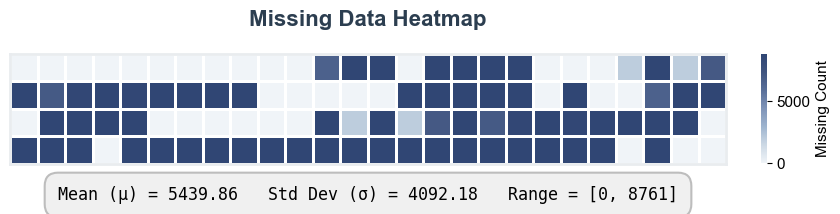

In [10]:
def create_modern_missing_data_heatmap(missing_counts_list: list, total_columns: int, title: str = "Missing Data Heatmap", save_path: str = None, rows: int = 8, cols: int = 13):
    """
    Creates a modern heatmap visualizing the intensity of missing data per column.

    Args:
        missing_counts_list (list): A list of missing counts for each column.
        total_columns (int): The total number of columns in the dataset.
        title (str): The title for the plot.
        save_path (str): Optional file path to save the plot (e.g., "heatmap.png").
        rows (int): The number of rows in the heatmap grid.
        cols (int): The number of columns in the heatmap grid.
    """
    # Pad or trim to match the grid dimensions
    total_cells = rows * cols
    if len(missing_counts_list) < total_cells:
        missing_counts_list += [0] * (total_cells - len(missing_counts_list))
    elif len(missing_counts_list) > total_cells:
        missing_counts_list = missing_counts_list[:total_cells]

    data_matrix = np.array(missing_counts_list).reshape(rows, cols)

    # Define a custom colormap for a modern aesthetic
    colors = ['#f0f4f8', '#cdd9e5', '#9fb5cf', '#7f94b8', '#5a709a', '#415580', '#304674']
    cmap = LinearSegmentedColormap.from_list('custom_pastel_blue', colors, N=256)

    # Configure Matplotlib rcParams for a clean, modern look
    plt.rcParams.update({
        'font.family': 'Arial',
        'font.size': 11,
        'axes.linewidth': 0,
        'figure.facecolor': 'white',
        'axes.facecolor': '#f8f9fa'
    })

    fig, ax = plt.subplots(figsize=(cols * 0.4, rows * 0.4 + 1))

    sns.heatmap(
        data_matrix,
        cmap=cmap,
        cbar_kws={
            'shrink': 0.6,
            'aspect': 20,
            'pad': 0.04,
            'label': 'Missing Count',
            'orientation': 'vertical'
        },
        square=True,
        linewidths=0.8,
        linecolor='white',
        xticklabels=False,
        yticklabels=False,
        ax=ax
    )

    ax.set_title(f'{title}', fontsize=16, fontweight='600', pad=20, color='#2c3e50')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_facecolor('#f8f9fa')
    fig.patch.set_facecolor('white')

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color('#e9ecef')

    # Add statistical summary to the plot
    stats_text = (
        f'Mean (μ) = {np.mean(missing_counts_list):.2f}   '
        f'Std Dev (σ) = {np.std(missing_counts_list):.2f}   '
        f'Range = [{np.min(missing_counts_list)}, {np.max(missing_counts_list)}]'
    )
    overlay_props = dict(boxstyle='round,pad=0.8', facecolor='#f0f0f0',
                         edgecolor='#bdbdbd', alpha=1.0, linewidth=1.5)

    dynamic_offset = -0.1 - (rows * 0.025)
    ax.text(0.5, dynamic_offset, stats_text, transform=ax.transAxes,
            fontsize=12, ha='center', va='top',
            bbox=overlay_props, family='monospace',
            color='black')

    fig.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.2)

    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='white', edgecolor='none')
        logging.info(f"Saved missing data heatmap to {save_path}")

    plt.show()

logger.info("Generating missing data heatmap...")

# Prepare missing counts for the heatmap, ensuring all columns are represented
missing_counts = missing_summary.set_index("column_name").reindex(data_df.columns)["missing_count"].fillna(0).astype(int).tolist()
create_modern_missing_data_heatmap(missing_counts, total_columns=len(data_df.columns), rows=4, cols=26, save_path=f"{PLOTS_SAVE_DIR}/heatmap.png")

# 5. Data Cleaning and Preprocessing
### NOTE: This section focuses on cleaning the raw data by removing irrelevant columns, handling missing values through imputation, and setting up the datetime index for time-series analysis.

### 5.1 Remove Fully Empty Columns
##### NOTE: This step identifies and removes columns that contain only missing values, as these columns provide no useful information for analysis.

In [11]:
# Determine the total number of rows in the original dataframe
total_rows = len(data_df)

# Find the names of columns where the missing count equals the total number of rows
columns_to_drop_fully_empty = missing_summary[missing_summary['missing_count'] == total_rows]['column_name'].tolist()

if columns_to_drop_fully_empty:
    # Drop the identified columns from the main dataframe
    data_df.drop(columns=columns_to_drop_fully_empty, inplace=True)

    logging.info(f"Removed {len(columns_to_drop_fully_empty)} fully empty columns: {columns_to_drop_fully_empty}")
    logging.info(f"New DataFrame shape after removing fully empty columns: {data_df.shape}")
else:
    logging.warning("No fully empty columns found to remove.")

INFO:root:Removed 51 fully empty columns: ['past_wx_id_2_j', 'cld_base_ht_id_4', 'visibility_j', 'cld_ht_j', 'cld_amt_id_j', 'vert_vsby_q', 'past_wx_id_1_j', 'alt_pres', 'ground_state_id', 'q10mnt_mxgst_spd', 'cavok_flag', 'cs_hr_sun_dur', 'snow_depth', 'prst_wx_id_j', 'wind_speed_j', 'past_wx_id_1_q', 'past_wx_id_2_q', 'wind_direction_j', 'low_cld_type_id_q', 'med_cld_type_id_q', 'hi_cld_type_id_q', 'snow_depth_q', 'cs_hr_sun_dur_q', 'q10mnt_mxgst_spd_q', 'alt_pres_q', 'ground_state_id_q', 'cloud_type_id_1_q', 'cloud_type_id_2_q', 'cloud_type_id_3_q', 'cld_amt_id_4_q', 'cloud_type_id_4_q', 'vert_vsby', 'cld_base_ht_id_4_q', 'cloud_type_id_4', 'air_temperature_j', 'q10mnt_mxgst_spd_j', 'alt_pres_j', 'stn_pres_j', 'vert_vsby_j', 'rltv_hum_j', 'past_wx_id_1', 'cld_amt_id_4', 'dewpoint_j', 'low_cld_type_id', 'med_cld_type_id', 'hi_cld_type_id', 'past_wx_id_2', 'cloud_type_id_2', 'msl_pressure_j', 'cloud_type_id_3', 'cloud_type_id_1']
INFO:root:New DataFrame shape after removing fully empt

### 5.2 Review Current Columns and Descriptions
##### NOTE: After initial column removal, this step provides an updated list of current columns and their descriptions, allowing for a re-assessment of relevant features.

In [12]:
# Get the list of current column names
column_list_after_empty_drop = data_df.columns.tolist()

# Log the list of column names
logging.info(f"Current DataFrame columns after removing empty ones: {column_list_after_empty_drop}")

logging.info("Updated column description table after removing fully empty columns:")
summary_table_cleaned = build_column_description_table(data_df, metadata_json)
display(summary_table_cleaned)

INFO:root:Current DataFrame columns after removing empty ones: ['ob_time', 'id', 'id_type', 'met_domain_name', 'version_num', 'src_id', 'rec_st_ind', 'wind_speed_unit_id', 'src_opr_type', 'wind_direction', 'wind_speed', 'prst_wx_id', 'cld_ttl_amt_id', 'cld_base_amt_id', 'cld_base_ht', 'visibility', 'msl_pressure', 'cld_amt_id_1', 'cld_base_ht_id_1', 'cld_amt_id_2', 'cld_base_ht_id_2', 'cld_amt_id_3', 'cld_base_ht_id_3', 'air_temperature', 'dewpoint', 'wetb_temp', 'rltv_hum', 'stn_pres', 'wmo_hr_sun_dur', 'wind_direction_q', 'wind_speed_q', 'prst_wx_id_q', 'cld_ttl_amt_id_q', 'cld_base_amt_id_q', 'cld_base_ht_q', 'visibility_q', 'msl_pressure_q', 'air_temperature_q', 'dewpoint_q', 'wetb_temp_q', 'cld_amt_id_1_q', 'cld_base_ht_id_1_q', 'cld_amt_id_2_q', 'cld_base_ht_id_2_q', 'cld_amt_id_3_q', 'cld_base_ht_id_3_q', 'stn_pres_q', 'wmo_hr_sun_dur_q', 'wetb_temp_j', 'meto_stmp_time', 'midas_stmp_etime', 'drv_hr_sun_dur', 'drv_hr_sun_dur_q']
INFO:root:Updated column description table after re

,column_name,column_description
0,ob_time,Date and time of observation
1,id,station identifier
2,id_type,identifier type
3,met_domain_name,message type
4,version_num,midas qc version number
5,src_id,unique source identifier or station site number
6,rec_st_ind,state indicator for the record
7,wind_speed_unit_id,Wind speed unit code
8,src_opr_type,source operation type code
9,wind_direction,wind direction


### 5.3 Remove Irrelevant Metadata/QC Columns
##### NOTE: This step removes columns that are identified as quality control flags, descriptors, or other non-measurement metadata, as they are not directly useful for prediction.

In [13]:
# Get the initial list of columns for comparison
original_columns_count = data_df.shape[1]

# Identify columns to remove based on their suffix (_q for quality control, _j for descriptor)
qc_cols = [col for col in data_df.columns if col.endswith('_q')]
descriptor_cols = [col for col in data_df.columns if col.endswith('_j')]

# Identify other metadata or ID columns that are not direct weather measurements
other_meta_cols = [
    'id',
    'id_type',
    'met_domain_name',
    'version_num',
    'src_id',
    'rec_st_ind',
    'src_opr_type',
    'meto_stmp_time',
    'midas_stmp_etime'
]

# Combine all columns to be dropped into a single list, ensuring no duplicates
columns_to_drop_irrelevant = list(set(qc_cols + descriptor_cols + other_meta_cols))

# Filter this list to only include columns that are actually present in the DataFrame
columns_to_drop_irrelevant = [col for col in columns_to_drop_irrelevant if col in data_df.columns]

if columns_to_drop_irrelevant:
    # Drop the identified columns from the DataFrame
    data_df.drop(columns=columns_to_drop_irrelevant, inplace=True)

    logging.info(f"Removed {len(columns_to_drop_irrelevant)} unnecessary metadata, QC, and descriptor columns.")
    logging.info(f"DataFrame shape changed from ({original_columns_count} columns) to ({data_df.shape[1]} columns).")
    logging.info(f"Remaining columns: {data_df.columns.tolist()}")
else:
    logging.info("No unnecessary metadata, QC, or descriptor columns found to remove.")

INFO:root:Removed 30 unnecessary metadata, QC, and descriptor columns.
INFO:root:DataFrame shape changed from (53 columns) to (23 columns).
INFO:root:Remaining columns: ['ob_time', 'wind_speed_unit_id', 'wind_direction', 'wind_speed', 'prst_wx_id', 'cld_ttl_amt_id', 'cld_base_amt_id', 'cld_base_ht', 'visibility', 'msl_pressure', 'cld_amt_id_1', 'cld_base_ht_id_1', 'cld_amt_id_2', 'cld_base_ht_id_2', 'cld_amt_id_3', 'cld_base_ht_id_3', 'air_temperature', 'dewpoint', 'wetb_temp', 'rltv_hum', 'stn_pres', 'wmo_hr_sun_dur', 'drv_hr_sun_dur']


### 5.4 Re-check Missing Values After Column Filtering
##### NOTE: After removing irrelevant columns, it's important to re-evaluate the missing values to understand the current data completeness.

In [14]:
# Calculate the sum of missing values for each column remaining in the DataFrame
missing_values_after_filter = data_df.isna().sum()

# Filter out columns that have no missing values
missing_values_after_filter = missing_values_after_filter[missing_values_after_filter > 0]

if not missing_values_after_filter.empty:
    # Convert the Series to a DataFrame for cleaner display
    missing_df_after_filter = missing_values_after_filter.reset_index()
    missing_df_after_filter.columns = ['column_name', 'missing_count']

    # Sort the results to show the most problematic columns first
    missing_df_after_filter = missing_df_after_filter.sort_values(by='missing_count', ascending=False).reset_index(drop=True)

    logging.info("\nColumns with missing values after initial filtering:")
    display(missing_df_after_filter)
else:
    logging.info("No missing values found in any of the remaining columns after initial filtering.")

INFO:root:
Columns with missing values after initial filtering:


,column_name,missing_count
0,cld_base_amt_id,8738
1,cld_amt_id_3,8610
2,cld_base_ht_id_3,8599
3,cld_amt_id_2,7069
4,cld_base_ht_id_2,7046
5,prst_wx_id,6623
6,cld_amt_id_1,1963
7,cld_base_ht_id_1,1963
8,drv_hr_sun_dur,32
9,visibility,12


### 5.5 Visualize Missing Values (Table Format)
##### NOTE: This visualization presents the counts of missing values in a wrapped table format.

INFO:root:Generating wrapped transposed table of missing values...
INFO:root:Saved wrapped transposed table of missing values to wrapped_transposed_table_missing_values.png


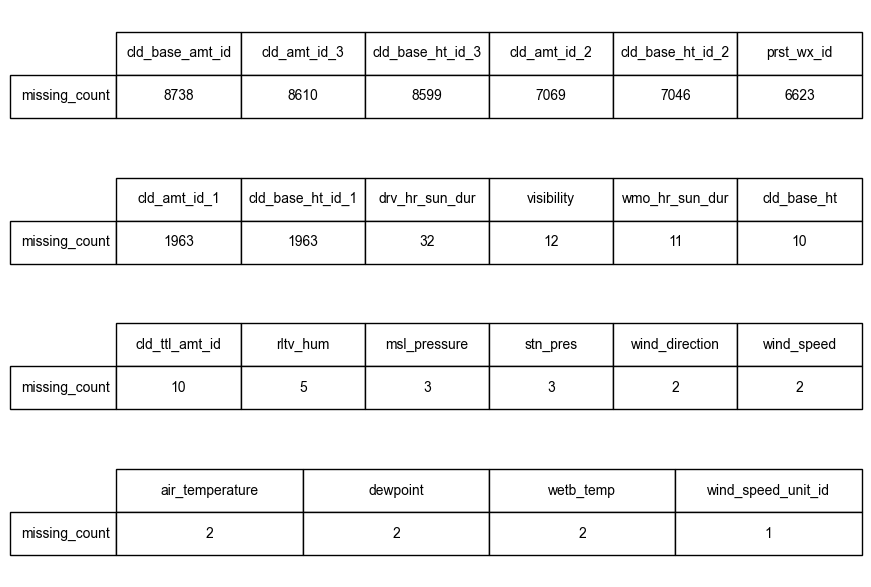

In [15]:
# Parameters for table visualization
total_columns_to_show = len(missing_df_after_filter)
n_blocks = 4  # Number of rows/blocks for the table display
columns_per_row = math.ceil(total_columns_to_show / n_blocks)

# Create list of block-tables to display in a wrapped format
blocks = []
for i in range(0, total_columns_to_show, columns_per_row):
    chunk = missing_df_after_filter.iloc[i:i + columns_per_row]
    # Transpose the chunk to have column names as headers and missing counts as rows
    transposed = chunk.set_index("column_name").T
    blocks.append(transposed)

# Plot each block in its own row
fig_height = 1.5 * n_blocks  # Adjust height based on number of blocks
fig, axes = plt.subplots(n_blocks, 1, figsize=(columns_per_row * 1.5, fig_height))

# Ensure axes is always iterable for consistent plotting
if n_blocks == 1:
    axes = [axes]

logging.info("Generating wrapped transposed table of missing values...")
for ax, block in zip(axes, blocks):
    ax.axis('off')  # Turn off axis for cleaner table display
    tbl = ax.table(cellText=block.values,
                   colLabels=block.columns,
                   rowLabels=block.index,
                   loc='center',
                   cellLoc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 2) # Adjust cell width and height

plt.tight_layout()
plt.savefig(f"{PLOTS_SAVE_DIR}/wrapped_transposed_table_missing_values.png", dpi=300)
logging.info("Saved wrapped transposed table of missing values to wrapped_transposed_table_missing_values.png")
plt.show()

### 5.6 Drop Columns with Excessive Missing Values
##### NOTE: This step removes specific columns that still have a high percentage of missing values even after initial cleaning, as they may not be reliably imputed or useful for analysis.

In [16]:
# Define the list of columns to drop due to high percentage of missing values
cols_to_drop_high_missing = ['wind_speed_unit_id', 'cld_ttl_amt_id', 'cld_base_ht', 'cld_amt_id_1', 'wmo_hr_sun_dur', 'drv_hr_sun_dur']

# Get the shape of the dataframe before dropping columns for logging
original_shape_before_dropping_high_missing = data_df.shape

# Drop the columns, using errors='ignore' to prevent a crash if a column isn't found
data_df.drop(columns=cols_to_drop_high_missing, inplace=True, errors='ignore')

logging.info(f"Dropped {len(cols_to_drop_high_missing)} columns with excessive missing values.")
logging.info(f"DataFrame shape changed from {original_shape_before_dropping_high_missing} to {data_df.shape}")

INFO:root:Dropped 6 columns with excessive missing values.
INFO:root:DataFrame shape changed from (8761, 23) to (8761, 17)


### 5.7 Drop Categorical Columns Not Useful for Feature Space
##### NOTE: This step removes additional categorical columns that, while not necessarily having excessive missing values, are deemed not beneficial for the predictive modeling feature space (e.g., specific cloud amount IDs that are highly discrete or descriptive).

In [17]:
# Drop the following columns as they are categorical and do not help the feature space
cols_to_drop_categorical = [
    'cld_base_amt_id',
    'cld_amt_id_3',
    'cld_base_ht_id_3',
    'cld_amt_id_2',
    'cld_base_ht_id_2',
    'prst_wx_id'
]

# Get the shape of the dataframe before dropping columns for logging
original_shape_before_dropping_categorical = data_df.shape

# Drop the columns, using errors='ignore' to prevent a crash if a column isn't found
data_df.drop(columns=cols_to_drop_categorical, inplace=True, errors='ignore')

logging.info(f"Dropped {len(cols_to_drop_categorical)} categorical columns not deemed useful for the feature space.")
logging.info(f"DataFrame shape changed from {original_shape_before_dropping_categorical} to {data_df.shape}")

INFO:root:Dropped 6 categorical columns not deemed useful for the feature space.
INFO:root:DataFrame shape changed from (8761, 17) to (8761, 11)


### 5.8 Datetime Indexing and Missing Value Imputation
##### NOTE: This step processes the 'ob_time' column to set it as a datetime index, which is essential for time-series operations. 
##### It then imputes remaining missing values using the mode for categorical-like columns and time-based interpolation for numerical columns.

In [18]:
# Clean and Set Datetime Index
if 'ob_time' in data_df.columns:
    logging.info("Cleaning and converting 'ob_time' to datetime index.")

    # Use errors='coerce' to turn any non-date strings (like 'end data') into NaT (Not a Time)
    data_df['ob_time'] = pd.to_datetime(data_df['ob_time'], errors='coerce')

    # Drop any rows where the conversion resulted in NaT
    initial_rows = len(data_df)
    data_df.dropna(subset=['ob_time'], inplace=True)
    dropped_rows = initial_rows - len(data_df)
    if dropped_rows > 0:
        logging.warning(f"Dropped {dropped_rows} rows due to invalid 'ob_time' entries.")

    # Set the clean datetime column as the index
    data_df.set_index('ob_time', inplace=True)
    logging.info("'ob_time' successfully set as DataFrame index.")
else:
    logging.error("'ob_time' column not found. Cannot proceed with time-based interpolation. Please ensure the column exists.")
    # Stop or handle gracefully if the index cannot be set
    raise ValueError("'ob_time' column is missing, cannot proceed with data processing.")

# Identify column types for imputation
# This heuristic categorizes columns based on the number of unique values. Columns with fewer than ~15 unique values are treated as potentially categorical.
categorical_cols = [col for col in data_df.columns if data_df[col].nunique() < 15 and pd.api.types.is_numeric_dtype(data_df[col])]
numerical_cols = [col for col in data_df.columns if pd.api.types.is_numeric_dtype(data_df[col]) and col not in categorical_cols]

logging.info(f"Identified {len(numerical_cols)} numerical columns for imputation.")
logging.info(f"Identified {len(categorical_cols)} categorical-like numerical columns for imputation (mode).")

# Impute Categorical-like Numerical Columns with the Mode
if categorical_cols:
    logging.info(f"Imputing categorical-like columns with mode: {categorical_cols}")
    for col in categorical_cols:
        if data_df[col].isna().any(): # Only impute if there are missing values
            mode_value = data_df[col].mode()[0]
            data_df[col] = data_df[col].fillna(mode_value)
            logging.info(f"Filled missing values in '{col}' with mode: {mode_value}")

# Impute Numerical Columns with Time-based Interpolation
if numerical_cols:
    logging.info(f"Imputing numerical columns with time-based interpolation: {numerical_cols}")
    for col in numerical_cols:
        if data_df[col].isna().any(): # Only interpolate if there are missing values
            data_df[col] = data_df[col].interpolate(method='time', limit_direction='both', limit_area='inside')
            # After time interpolation, any remaining NaNs (e.g., at ends of series) are filled with mean
            if data_df[col].isna().any():
                mean_value = data_df[col].mean()
                data_df[col] = data_df[col].fillna(mean_value)
                logging.warning(f"Filled remaining missing values in '{col}' with mean after time interpolation: {mean_value:.2f}")


# Verification
remaining_missing = data_df.isna().sum().sum()
if remaining_missing == 0:
    logging.info("Successfully imputed all missing values. No missing data remains in the dataset.")
else:
    logging.warning(f"Warning: {remaining_missing} missing values still remain in the dataset after imputation.")
    # Display columns that still have missing values
    remaining_missing_cols = data_df.isna().sum()
    remaining_missing_cols = remaining_missing_cols[remaining_missing_cols > 0]
    logging.info("Columns with remaining missing values:")
    display(remaining_missing_cols.to_frame(name='missing_count'))

INFO:root:Cleaning and converting 'ob_time' to datetime index.
INFO:root:'ob_time' successfully set as DataFrame index.
INFO:root:Identified 10 numerical columns for imputation.
INFO:root:Identified 0 categorical-like numerical columns for imputation (mode).
INFO:root:Imputing numerical columns with time-based interpolation: ['wind_direction', 'wind_speed', 'visibility', 'msl_pressure', 'cld_base_ht_id_1', 'air_temperature', 'dewpoint', 'wetb_temp', 'rltv_hum', 'stn_pres']
INFO:root:Successfully imputed all missing values. No missing data remains in the dataset.


### 5.9 Final Check for Missing Values
##### NOTE: This final check confirms whether any missing values persist after all imputation steps, ensuring the data is ready for modeling.

In [19]:
# Calculate the sum of missing values for each column after all imputation steps
final_missing_values = data_df.isna().sum()

# Filter out columns that have no missing values
final_missing_values = final_missing_values[final_missing_values > 0]

if not final_missing_values.empty:
    # Convert the Series to a DataFrame for nicer display
    final_missing_df = final_missing_values.reset_index()
    final_missing_df.columns = ['column_name', 'missing_count']

    # Sort the results
    final_missing_df = final_missing_df.sort_values(by='missing_count', ascending=False).reset_index(drop=True)

    logging.info("\nColumns with missing values after all cleaning and imputation:")
    display(final_missing_df)
    logging.warning(f"Warning: {final_missing_df['missing_count'].sum()} missing values still remain in the dataset.")
else:
    logging.info("No missing values found in any of the remaining columns after all cleaning and imputation.")
    logging.info("No missing values remaining.")

INFO:root:No missing values found in any of the remaining columns after all cleaning and imputation.
INFO:root:No missing values remaining.


# 6. Statistical Analysis and Feature Understanding
##### NOTE: This section delves into the statistical properties of the cleaned dataset and explores feature distributions, laying the groundwork for feature selection.

### 6.1 Descriptive Statistics
##### NOTE: This subsection provides a summary of descriptive statistics for both numerical and categorical columns, offering insights into central tendency, dispersion, and value counts.

In [20]:
logging.info("\nDescriptive Statistics for Numerical Columns")
numerical_stats = data_df.describe(include='number')
display(numerical_stats)

logging.info("\nDescriptive Statistics for Categorical Columns")
categorical_columns_for_stats = data_df.select_dtypes(include=['object', 'category']).columns

if not categorical_columns_for_stats.empty:
    categorical_stats = data_df[categorical_columns_for_stats].describe()
    display(categorical_stats)
else:
    logging.info("No categorical or object columns found in the DataFrame.")

INFO:root:
Descriptive Statistics for Numerical Columns


,wind_direction,wind_speed,visibility,msl_pressure,cld_base_ht_id_1,air_temperature,dewpoint,wetb_temp,rltv_hum,stn_pres
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,192.091324,8.120662,2963.157534,1014.139600,172.730137,12.393779,8.038590,10.190782,76.760382,1011.112803
std,94.058137,4.340243,1600.464566,12.317834,184.294819,6.186038,4.929069,5.005144,15.325956,12.277913
min,0.000000,0.000000,0.000000,955.700000,3.000000,-8.300000,-9.300000,-8.600000,26.900000,952.900000
25%,130.000000,5.000000,1800.000000,1007.100000,48.000000,8.200000,4.900000,6.800000,66.900000,1004.100000
50%,210.000000,7.000000,3000.000000,1015.100000,101.125000,11.900000,8.100000,10.100000,80.350000,1012.100000
75%,260.000000,11.000000,4000.000000,1022.400000,210.000000,16.800000,11.600000,14.100000,89.000000,1019.400000
max,360.000000,27.000000,7500.000000,1046.800000,750.000000,32.500000,19.800000,22.700000,99.200000,1043.600000


INFO:root:
Descriptive Statistics for Categorical Columns
INFO:root:No categorical or object columns found in the DataFrame.


### 6.2 Feature Distribution Plots
##### NOTE: This subsection visualizes the distributions of key numerical features using histograms and Kernel Density Estimates (KDEs), helping to identify skewness, outliers, and patterns.

INFO:root:Generating distribution plots for key numerical features...
INFO:root:Plots grid saved to _plots/numerical_distributions_grid.png


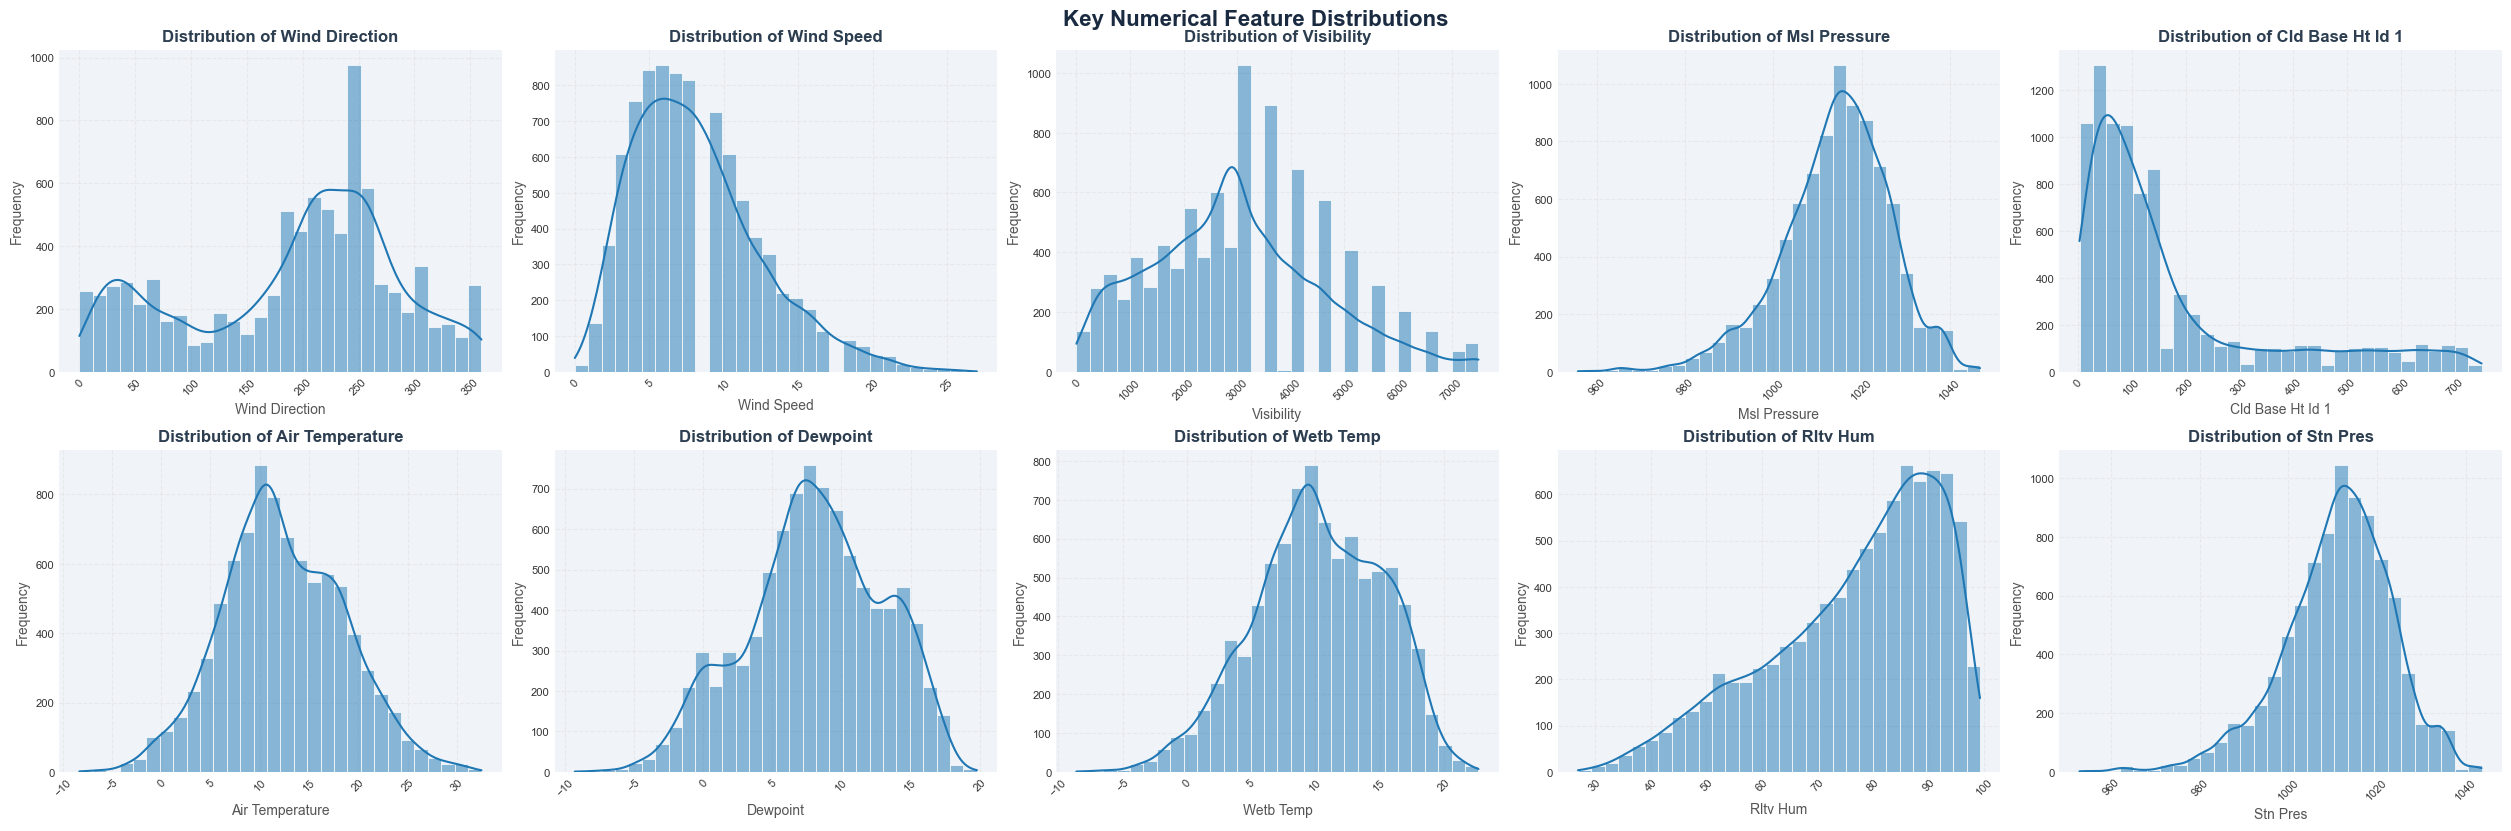

In [21]:
def create_distribution_plots_grid(df: pd.DataFrame, columns: list = None, title_prefix: str = "Distribution of", bins: int = 30, hue_column: str = None, save_path: str = None, grid_rows: int = None, grid_cols: int = None):
    """
    Creates a grid of distribution plots (histograms and KDEs) for specified numerical columns
    using Seaborn, with a modern aesthetic.

    Args:
        df (pd.DataFrame): The DataFrame containing the numerical data.
        columns (list): A list of numerical column names to plot. If None, all numerical columns will be used.
        title_prefix (str): Prefix for the plot titles.
        bins (int): Number of bins for the histogram.
        hue_column (str): Optional. A column to use for color encoding (e.g., 'season').
        save_path (str): Optional file path to save the plot.
        grid_rows (int): Optional. Explicit number of rows for the subplot grid.
        grid_cols (int): Optional. Explicit number of columns for the subplot grid.
    """
    if columns is None:
        numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    else:
        numerical_cols = [col for col in columns if pd.api.types.is_numeric_dtype(df[col])]

    if not numerical_cols:
        logging.info("No numerical columns found to plot.")
        return

    # Determine grid size based on explicit parameters or dynamically
    n_plots = len(numerical_cols)
    if grid_cols is not None and grid_rows is not None:
        n_cols = grid_cols
        n_rows = grid_rows
    elif grid_cols is not None:
        n_cols = grid_cols
        n_rows = math.ceil(n_plots / n_cols)
    elif grid_rows is not None:
        n_rows = grid_rows
        n_cols = math.ceil(n_plots / n_rows)
    else:
        n_cols = 3  # Default number of columns if not specified
        n_rows = math.ceil(n_plots / n_cols)

    # Configure Matplotlib and Seaborn styles for a modern look (what would be considered "basic", but rather minimalist)
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'axes.facecolor': '#f0f4f8',
        'figure.facecolor': 'white',
        'axes.edgecolor': '#cccccc',
        'grid.color': '#e0e0e0',
        'text.color': '#333333',
        'axes.labelcolor': '#333333',
        'xtick.color': '#333333',
        'ytick.color': '#333333',
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 9,
        'figure.titlesize': 14
    })

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), constrained_layout=True)
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    for i, col in enumerate(numerical_cols):
        ax = axes[i]
        # Conditionally pass the palette argument only if hue_column is provided
        if hue_column and hue_column in df.columns:
            sns.histplot(data=df, x=col, kde=True, bins=bins, ax=ax, palette='viridis', hue=hue_column, edgecolor='white', linewidth=0.5)
        else:
            sns.histplot(data=df, x=col, kde=True, bins=bins, ax=ax, edgecolor='white', linewidth=0.5)
        ax.set_title(f'{title_prefix} {col.replace("_", " ").title()}', fontsize=12, fontweight='bold', color='#2c3e50')
        ax.set_xlabel(col.replace("_", " ").title(), fontsize=10, color='#555555')
        ax.set_ylabel('Frequency', fontsize=10, color='#555555')
        ax.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability
        ax.grid(True, linestyle='--', alpha=0.6)

        # Remove top and right spines
        sns.despine(ax=ax, top=True, right=True)

    # Remove any unused subplots
    for j in range(n_plots, len(axes)): 
        fig.delaxes(axes[j])

    fig.suptitle("Key Numerical Feature Distributions", fontsize=16, fontweight='bold', color='#1a2a40', y=1.02)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
        logging.info(f"Plots grid saved to {save_path}")

    plt.show()

# Plotting the 10 specified columns in a 2x5 grid
columns_to_plot = [
    'wind_direction',
    'wind_speed',
    'visibility',
    'msl_pressure',
    'cld_base_ht_id_1',
    'air_temperature',
    'dewpoint',
    'wetb_temp',
    'rltv_hum',
    'stn_pres'
]

logging.info("Generating distribution plots for key numerical features...")
create_distribution_plots_grid(data_df, columns=columns_to_plot, save_path=f"{PLOTS_SAVE_DIR}/numerical_distributions_grid.png", grid_rows=2, grid_cols=5)

# 7. Feature Engineering and Selection
##### NOTE: This section explores techniques to reduce dimensionality and identify the most impactful features for prediction, using PCA and XGBoost feature importance.

### 7.1 Principal Component Analysis (PCA)
##### NOTE: PCA is applied to understand the variance explained by different principal components, which can inform dimensionality reduction strategies while retaining most of the data's information. Useful to create a faster and smaller model.

INFO:root:
Performing Principal Component Analysis (PCA)
INFO:root:Features scaled for PCA.


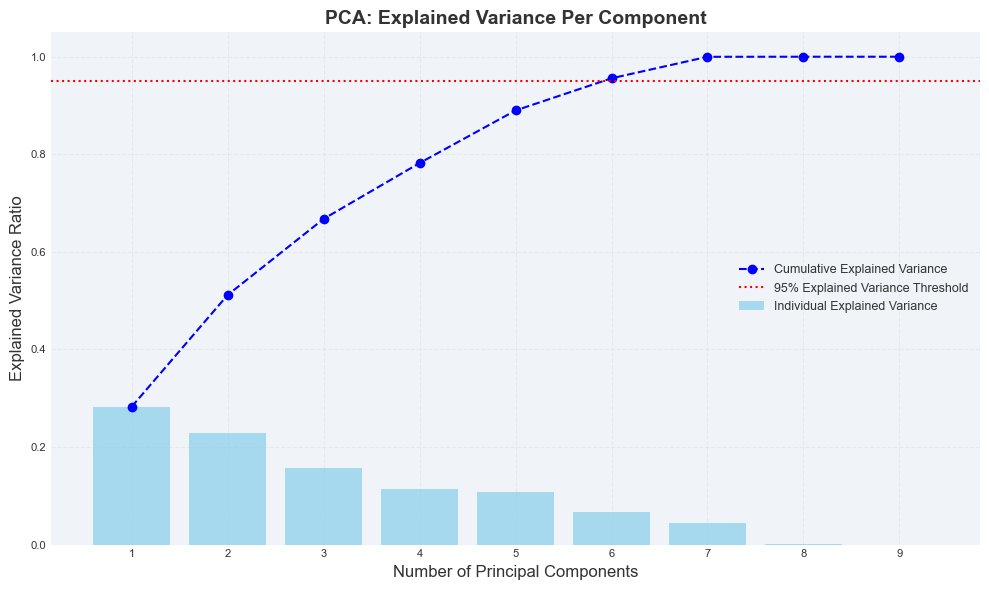

INFO:root:
Explained variance by each principal component:
INFO:root:PC 1: 0.2825 (Cumulative: 0.2825)
INFO:root:PC 2: 0.2291 (Cumulative: 0.5116)
INFO:root:PC 3: 0.1560 (Cumulative: 0.6676)
INFO:root:PC 4: 0.1144 (Cumulative: 0.7820)
INFO:root:PC 5: 0.1078 (Cumulative: 0.8898)
INFO:root:PC 6: 0.0660 (Cumulative: 0.9558)
INFO:root:PC 7: 0.0441 (Cumulative: 0.9998)
INFO:root:PC 8: 0.0002 (Cumulative: 1.0000)
INFO:root:PC 9: 0.0000 (Cumulative: 1.0000)
INFO:root:Approximately 6 principal components are needed to explain over 95% of the variance.


In [22]:
# Define the numerical columns for PCA analysis (excluding the target if it's 'air_temperature')
features_for_pca_analysis = [
    'wind_direction',
    'wind_speed',
    'visibility',
    'msl_pressure',
    'cld_base_ht_id_1',
    'dewpoint',
    'wetb_temp',
    'rltv_hum',
    'stn_pres'
]

# Ensure all features for analysis exist in the DataFrame
features_for_pca_analysis = [col for col in features_for_pca_analysis if col in data_df.columns]

if not features_for_pca_analysis:
    logging.error("No valid numerical features found for PCA analysis. Skipping PCA.")
else:
    logging.info("\nPerforming Principal Component Analysis (PCA)")

    # Standardize the data before applying PCA
    scaler_pca = StandardScaler()
    scaled_features_pca = scaler_pca.fit_transform(data_df[features_for_pca_analysis])
    scaled_df_pca = pd.DataFrame(scaled_features_pca, columns=features_for_pca_analysis, index=data_df.index)
    logging.info("Features scaled for PCA.")

    # Apply PCA (get all components)
    pca = PCA() 
    pca.fit(scaled_df_pca)

    # Explained Variance Plot
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='blue', label='Cumulative Explained Variance')
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, color='skyblue', label='Individual Explained Variance')
    plt.xlabel('Number of Principal Components', fontsize=12)
    plt.ylabel('Explained Variance Ratio', fontsize=12)
    plt.title('PCA: Explained Variance Per Component', fontsize=14, fontweight='bold')
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(y=0.95, color='r', linestyle=':', label='95% Explained Variance Threshold')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{PLOTS_SAVE_DIR}/pca_features.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()

    logging.info("\nExplained variance by each principal component:")
    for i, variance in enumerate(explained_variance_ratio):
        logging.info(f"PC {i+1}: {variance:.4f} (Cumulative: {cumulative_explained_variance[i]:.4f})")

    # Identify number of components for 95% variance
    n_components_95 = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1
    logging.info(f"Approximately {n_components_95} principal components are needed to explain over 95% of the variance.")

#### 7.1.1 PCA Interpretation
##### NOTE: This section provides an interpretation of the PCA results, indicating how many principal components are needed to explain a significant portion of the dataset's variance.

The PCA results illustrate the contribution of each principal component (PC) to the total variance within the dataset. Specifically:

* **PC1** accounts for approximately 28.25% of the variance.
* **PC2** explains an additional 22.91%, bringing the cumulative explained variance to 51.16%.
* By **PC6** (the sixth principal component), the cumulative explained variance surpasses the 95% threshold, reaching 95.58%.

This indicates that roughly 6 principal components are sufficient to capture over 95% of the information contained in the original 9 numerical features. Utilizing PCA for dimensionality reduction, from 9 features down to 6 principal components, can help in reducing noise, improving model performance, and accelerating the training process due to the smaller feature space.

### 7.2 XGBoost Feature Importance
##### NOTE: XGBoost is used to determine the importance of each feature for various target variables. This helps in selecting the most predictive features for specific modeling tasks.
PCA used previously is a standard within Data Analytics and especially ML fields, however, the XGBoost Feature Importance capability is more powerful and dynamic. Therefore, I have moved to it and applied it to all 4 targets (labels) for the 4 regression models we'll build later.

INFO:root:
Calculating XGBoost Feature Importances for Multiple Targets
INFO:root:Combined XGBoost feature importance plot saved to: _plots\all_targets_xgboost_feature_importance.png


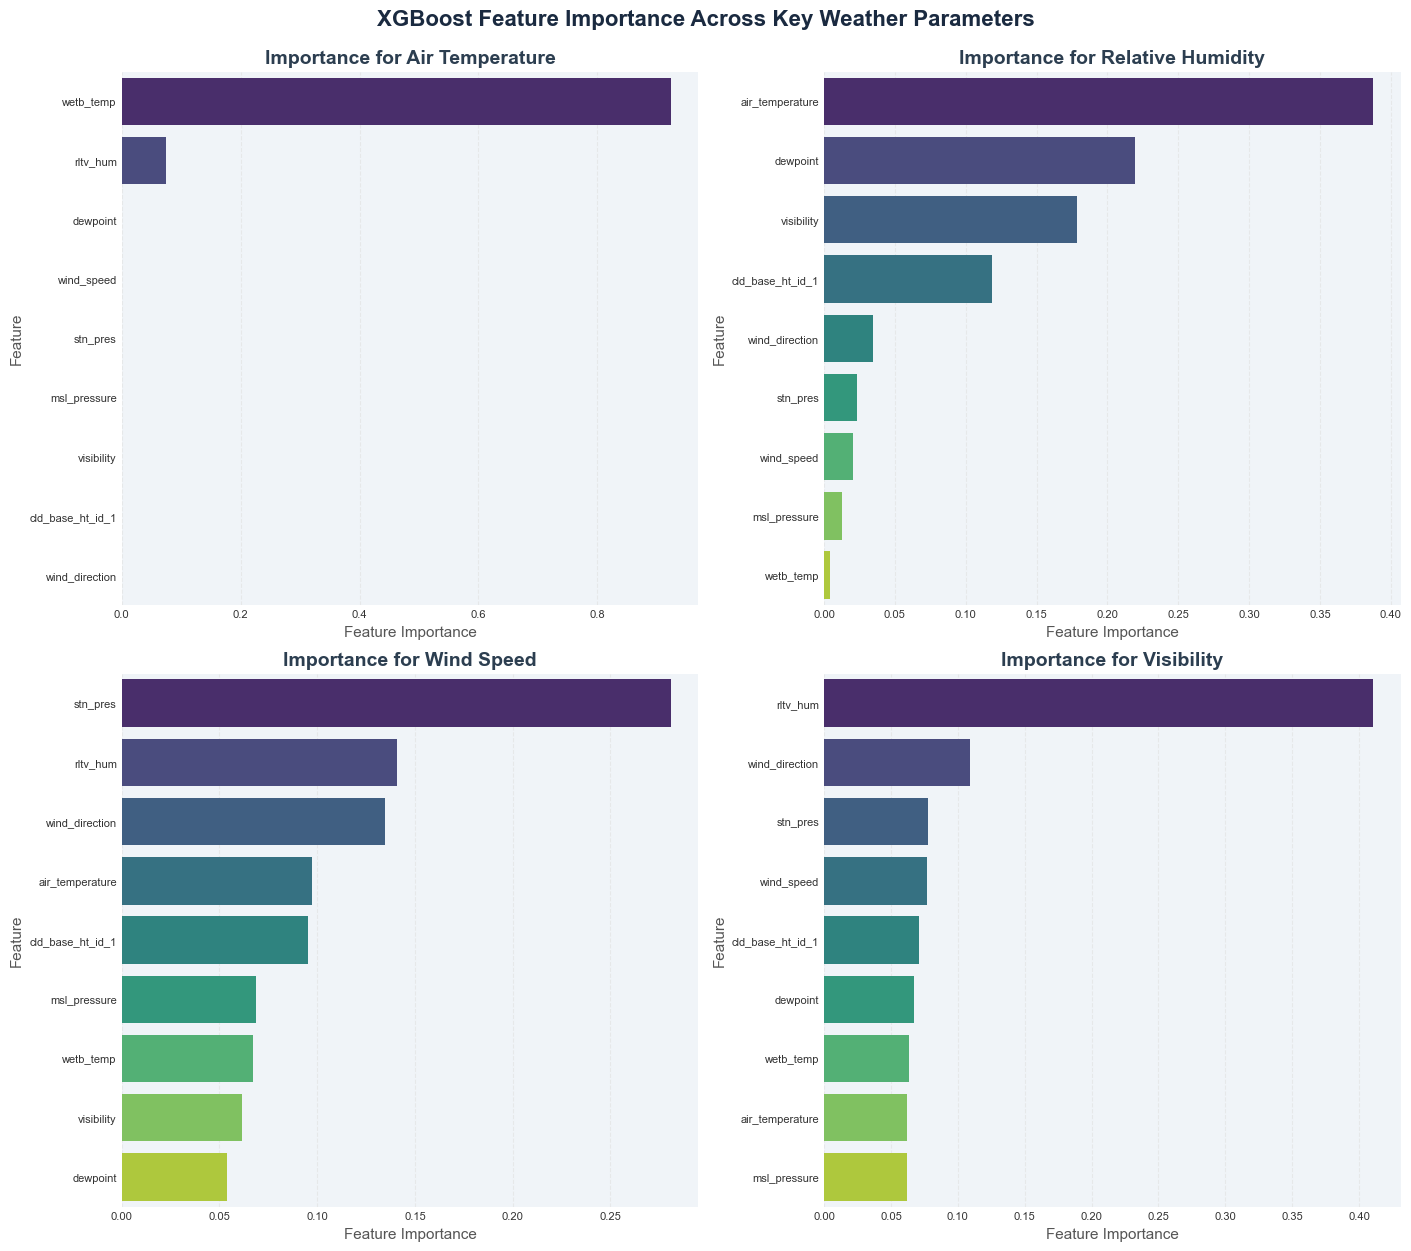

INFO:root:
Summary Table of XGBoost Feature Importances


,air_temperature,rltv_hum,wind_speed,visibility
wetb_temp,0.923716,0.004315,0.067097,0.063534
rltv_hum,0.07529,N/A,0.140931,0.410694
air_temperature,N/A,0.387739,0.09734,0.062204
stn_pres,0.000094,0.023255,0.280972,0.077535
dewpoint,0.000502,0.219458,0.053701,0.067274
cld_base_ht_id_1,0.000069,0.118874,0.095343,0.07092
wind_direction,0.000054,0.034404,0.134494,0.109271
visibility,0.000084,0.178421,0.061348,N/A
msl_pressure,0.000093,0.01279,0.068774,0.061678
wind_speed,0.000098,0.020745,N/A,0.076889


In [23]:
# List of all numerical columns that can serve as features or targets
all_numerical_cols_for_importance = [
    'wind_direction', 'wind_speed', 'visibility', 'msl_pressure',
    'cld_base_ht_id_1', 'air_temperature', 'dewpoint', 'wetb_temp',
    'rltv_hum', 'stn_pres'
]

# Define the target variables for which to calculate feature importance
target_columns_for_importance = {
    'air_temperature': 'Air Temperature',
    'rltv_hum': 'Relative Humidity',
    'wind_speed': 'Wind Speed',
    'visibility': 'Visibility'
}

# Dictionary to store feature importance DataFrames for each target
all_importances = {}

# Set up the matplotlib style for a clean look
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'axes.facecolor': '#f0f4f8',
    'figure.facecolor': 'white',
    'axes.edgecolor': '#cccccc',
    'grid.color': '#e0e0e0',
    'text.color': '#333333',
    'axes.labelcolor': '#333333',
    'xtick.color': '#333333',
    'ytick.color': '#333333',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 9,
    'figure.titlesize': 14
})

# Create a 2x2 grid for the plots
# We create this figure outside the loop to place all subplots on one combined figure.
fig, axes = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)
axes = axes.flatten() # Flatten for easy iteration

logging.info("\nCalculating XGBoost Feature Importances for Multiple Targets")

for i, (target_col, plot_title) in enumerate(target_columns_for_importance.items()):
    ax = axes[i]

    # Features for the current model (all numerical except the current target)
    features_for_current_model = [col for col in all_numerical_cols_for_importance if col != target_col and col in data_df.columns]

    if not features_for_current_model:
        logging.warning(f"Skipping {target_col}: No valid feature columns available.")
        fig.delaxes(ax) # Remove unused subplot
        continue

    X = data_df[features_for_current_model]
    y = data_df[target_col]

    # Align indices to ensure X and y match
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    if X.empty or y.empty:
        logging.warning(f"Skipping {target_col}: Data is empty after index alignment or contains non-finite values. Rows with NaNs/Infs will be dropped.")
        # Drop rows with NaN or Inf values in X or y for this specific calculation
        finite_mask = np.isfinite(y) & np.isfinite(X).all(axis=1)
        X = X[finite_mask]
        y = y[finite_mask]
        
        if X.empty or y.empty:
            logging.error(f"Skipping {target_col}: No finite data remaining after cleaning for importance calculation.")
            fig.delaxes(ax) # Remove unused subplot
            continue

    # Scale features
    scaler_importance = StandardScaler()
    X_scaled = scaler_importance.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # Initialize and train an XGBoost Regressor model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=N_JOBS, tree_method=TREE_METHOD)
    model.fit(X_scaled_df, y)

    # Get feature importances
    feature_importances = model.feature_importances_
    feature_names = X_scaled_df.columns

    # Create a DataFrame for this target's importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    all_importances[target_col] = importance_df

    # Plotting on the current subplot
    sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax, palette='viridis', hue='Feature', legend=False, dodge=False)
    ax.set_title(f'Importance for {plot_title}', fontsize=14, fontweight='bold', color='#2c3e50')
    ax.set_xlabel('Feature Importance', fontsize=11, color='#555555')
    ax.set_ylabel('Feature', fontsize=11, color='#555555')
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    sns.despine(ax=ax, top=True, right=True)

fig.suptitle('XGBoost Feature Importance Across Key Weather Parameters', fontsize=16, fontweight='bold', color='#1a2a40', y=1.03)

# Save the combined figure to PLOTS_SAVE_DIR
plot_filename = os.path.join(PLOTS_SAVE_DIR, 'all_targets_xgboost_feature_importance.png')
plt.savefig(plot_filename, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
logging.info(f"Combined XGBoost feature importance plot saved to: {plot_filename}")

plt.show() # Display the combined plot


logging.info("\nSummary Table of XGBoost Feature Importances")

# Get all unique feature names that were ever used
all_feature_names = sorted(list(set(col for imp_df in all_importances.values() for col in imp_df['Feature'])))

# Create an empty DataFrame for the summary table with object dtype to allow mixed types
summary_table = pd.DataFrame(index=all_feature_names, columns=list(target_columns_for_importance.keys()), dtype=object)

# Populate the table
for target_col, importance_df in all_importances.items():
    for _, row in importance_df.iterrows():
        feature = row['Feature']
        importance = row['Importance']
        summary_table.loc[feature, target_col] = importance

# Fill the diagonal (where feature == target) with 'N/A' similar to how a confusion matrix would be
for target_col in target_columns_for_importance.keys():
    if target_col in summary_table.index:
        summary_table.loc[target_col, target_col] = 'N/A'

# Create a temporary DataFrame for sorting, converting values to float where possible
temp_summary_for_sort = summary_table.copy()
for col in temp_summary_for_sort.columns:
    # Attempt to convert to numeric, coercing errors to NaN
    temp_summary_for_sort[col] = pd.to_numeric(temp_summary_for_sort[col], errors='coerce')

# Fill NaNs with 0 for mean calculation before sorting
temp_summary_for_sort = temp_summary_for_sort.fillna(0)

# Sort the rows, features, by their average importance across targets
summary_table = summary_table.loc[temp_summary_for_sort.mean(axis=1).sort_values(ascending=False).index]

# Display the summary table
display(summary_table)

#### 7.2.1 XGBoost Feature Importance Interpretation
##### NOTE: This section interprets the feature importance results from XGBoost for each target variable, highlighting which features are most influential for specific weather parameter predictions.

The table above displays the relative importance of each feature in predicting different target weather variables. A higher numerical value indicates greater importance for that specific prediction task. 'N/A' denotes that the feature is the target variable itself and, therefore, is not used as a predictor in that particular model.

Here's a detailed breakdown by target variable:

**Predicting `air_temperature`:**
* `wetb_temp` (wet-bulb temperature) is overwhelmingly the most important feature, with an importance score of 0.9237. This is logical, as wet-bulb temperature is intrinsically linked to both air temperature and humidity.
* `rltv_hum` (relative humidity) is the second most important feature, though with a significantly lower score of 0.0753.
* Other features show negligible importance for `air_temperature` prediction.

**Predicting `rltv_hum` (Relative Humidity):**
* `air_temperature` (0.3877) and `dewpoint` (0.2195) are the most crucial predictors for relative humidity, which aligns with the meteorological definition of relative humidity being a function of both.
* `visibility` (0.1784) and `cld_base_ht_id_1` (0.1189) also demonstrate notable importance.
* `wetb_temp`, `wind_direction`, `stn_pres`, `msl_pressure`, and `wind_speed` have lower importance in predicting humidity.

**Predicting `wind_speed`:**
* `stn_pres` (station pressure) is the most important feature (0.2810), followed by `rltv_hum` (0.1409) and `wind_direction` (0.1345).
* `air_temperature`, `cld_base_ht_id_1`, and `wetb_temp` also contribute, but their significance is comparatively lower.
* `dewpoint`, `visibility`, and `msl_pressure` show relatively low importance for `wind_speed` prediction.

**Predicting `visibility`:**
* `rltv_hum` (relative humidity) is the dominant predictor, with an importance of 0.4107. This is highly logical, as elevated humidity levels often lead to reduced visibility due to phenomena like fog or haze.
* `wind_direction` (0.1093) and `stn_pres` (0.0775) are the next most important features.
* `cld_base_ht_id_1`, `dewpoint`, `wetb_temp`, `air_temperature`, `msl_pressure`, and `wind_speed` exhibit some, but generally low, importance.

**Overall Observations:**

This analysis clearly indicates that the importance of features varies significantly depending on the target weather parameter being predicted. For instance, `wetb_temp` is exceptionally important for `air_temperature` prediction. `rltv_hum` is a strong indicator for `visibility`, while `air_temperature` and `dewpoint` are critical for `rltv_hum`. Pressure-related features, specifically `stn_pres`, appear to be more influential in `wind_speed` prediction. Conversely, some features, such as `msl_pressure`, consistently show lower importance across multiple target variables.

### 7.3 Interractive Feature Importance Plot
##### NOTE: This uses Plotly's great 3D features in Jupyter Notebook to create an interractive widgets and access the data as a 3D scatterplot based on the top 3 most relevant features selected by XGBoost Feature Importance.

#### 7.3.1 Plot Setup for 3D Interactive Scatter Plots
##### NOTE: This section prepares the necessary data and identifies the top 3 features for each target variable, which will be used in the subsequent individual 3D scatter plots.

In [26]:
logging.info("\nPlot Setup for 3D Interactive Scatter Plots with Plotly #")

# Define the targets for which to create plots and their display names
plot_targets = {
    'air_temperature': 'Air Temperature',
    'rltv_hum': 'Relative Humidity',
    'visibility': 'Visibility',
    'wind_speed': 'Wind Speed'
}

# Dictionary to store the top 3 features and plotting data for each target
plot_data_storage = {}

for target_col, plot_title_display in plot_targets.items():
    logging.info(f"Preparing data for {plot_title_display} plot...")
    try:
        # Get the importance series for the current target, drop the target itself if present in index
        target_importances = summary_table.loc[:, target_col].drop(target_col, errors='ignore')
        # Convert to numeric, coercing errors to NaN and filling with 0 for sorting
        target_importances_numeric = pd.to_numeric(target_importances, errors='coerce').fillna(0)

        # Get the top 3 feature names
        top_3_features = target_importances_numeric.nlargest(3).index.tolist()

        # Filter to ensure features actually exist in the DataFrame
        relevant_features_in_df = [f for f in top_3_features if f in data_df.columns]

        if len(relevant_features_in_df) < 3:
            logging.warning(f"Not enough (at least 3) relevant features found for {plot_title_display} after filtering. Skipping data preparation for this target.")
            continue

        # Use only the top 3 available features
        feature1, feature2, feature3 = relevant_features_in_df[:3]

        # Prepare data for plotting: select relevant columns and drop rows with any NaNs
        current_plot_df = data_df[[feature1, feature2, feature3, target_col]].dropna().copy()

        if current_plot_df.empty:
            logging.warning(f"Plotting DataFrame for {plot_title_display} is empty after dropping NaNs. Skipping data preparation for this target.")
            continue

        # Store the prepared data and features
        plot_data_storage[target_col] = {
            'plot_df': current_plot_df,
            'features': [feature1, feature2, feature3],
            'display_name': plot_title_display
        }
        logging.info(f"Data prepared for {plot_title_display} using features: {feature1}, {feature2}, {feature3}.")

    except Exception as e:
        logging.error(f"An error occurred during data preparation for {plot_title_display}: {e}", exc_info=True)

INFO:root:
Plot Setup for 3D Interactive Scatter Plots with Plotly #
INFO:root:Preparing data for Air Temperature plot...
INFO:root:Data prepared for Air Temperature using features: wetb_temp, rltv_hum, dewpoint.
INFO:root:Preparing data for Relative Humidity plot...
INFO:root:Data prepared for Relative Humidity using features: air_temperature, dewpoint, visibility.
INFO:root:Preparing data for Visibility plot...
INFO:root:Data prepared for Visibility using features: rltv_hum, wind_direction, stn_pres.
INFO:root:Preparing data for Wind Speed plot...
INFO:root:Data prepared for Wind Speed using features: stn_pres, rltv_hum, wind_direction.


#### 7.3.2 3D Interactive Scatter Plot for Air Temperature
##### NOTE: This section visualizes the 'Air Temperature' against its top 3 most important features in an interactive 3D scatter plot.

In [35]:
target_col = 'air_temperature'
if target_col in plot_data_storage:
    plot_info = plot_data_storage[target_col]
    plot_df = plot_info['plot_df']
    feature1, feature2, feature3 = plot_info['features']
    plot_title_display = plot_info['display_name']

    logging.info(f"Generating plot for {plot_title_display}...")
    fig = px.scatter_3d(plot_df,
                        x=feature1,
                        y=feature2,
                        z=feature3,
                        color=target_col,
                        title=f'3D Scatter Plot: {plot_title_display} vs. Top 3 Features',
                        labels={
                            feature1: feature1.replace('_', ' ').title(),
                            feature2: feature2.replace('_', ' ').title(),
                            feature3: feature3.replace('_', ' ').title(),
                            target_col: target_col.replace('_', ' ').title()
                        },
                        height=700)
    fig.show()
else:
    logging.warning(f"Skipping {target_col} plot: Data not prepared or insufficient features.")

INFO:root:Generating plot for Air Temperature...


#### 7.3.3 3D Interactive Scatter Plot for Relative Humidity
##### NOTE: This section visualizes the 'Relative Humidity' against its top 3 most important features in an interactive 3D scatter plot.

In [37]:
target_col = 'rltv_hum'
if target_col in plot_data_storage:
    plot_info = plot_data_storage[target_col]
    plot_df = plot_info['plot_df']
    feature1, feature2, feature3 = plot_info['features']
    plot_title_display = plot_info['display_name']

    logging.info(f"Generating plot for {plot_title_display}...")
    fig = px.scatter_3d(plot_df,
                        x=feature1,
                        y=feature2,
                        z=feature3,
                        color=target_col,
                        title=f'3D Scatter Plot: {plot_title_display} vs. Top 3 Features',
                        labels={
                            feature1: feature1.replace('_', ' ').title(),
                            feature2: feature2.replace('_', ' ').title(),
                            feature3: feature3.replace('_', ' ').title(),
                            target_col: target_col.replace('_', ' ').title()
                        },
                        height=700)
    fig.show()
else:
    logging.warning(f"Skipping {target_col} plot: Data not prepared or insufficient features.")

INFO:root:Generating plot for Relative Humidity...


#### 7.3.4 3D Interactive Scatter Plot for Visibility
##### NOTE: This section visualizes the 'Visibility' against its top 3 most important features in an interactive 3D scatter plot.

In [39]:
target_col = 'visibility'
if target_col in plot_data_storage:
    plot_info = plot_data_storage[target_col]
    plot_df = plot_info['plot_df']
    feature1, feature2, feature3 = plot_info['features']
    plot_title_display = plot_info['display_name']

    logging.info(f"Generating plot for {plot_title_display}...")
    fig = px.scatter_3d(plot_df,
                        x=feature1,
                        y=feature2,
                        z=feature3,
                        color=target_col,
                        title=f'3D Scatter Plot: {plot_title_display} vs. Top 3 Features',
                        labels={
                            feature1: feature1.replace('_', ' ').title(),
                            feature2: feature2.replace('_', ' ').title(),
                            feature3: feature3.replace('_', ' ').title(),
                            target_col: target_col.replace('_', ' ').title()
                        },
                        height=700)
    fig.show()
else:
    logging.warning(f"Skipping {target_col} plot: Data not prepared or insufficient features.")

INFO:root:Generating plot for Visibility...


#### 7.3.5 3D Interactive Scatter Plot for Wind Speed
##### NOTE: This section visualizes the 'Wind Speed' against its top 3 most important features in an interactive 3D scatter plot.

In [41]:
target_col = 'wind_speed'
if target_col in plot_data_storage:
    plot_info = plot_data_storage[target_col]
    plot_df = plot_info['plot_df']
    feature1, feature2, feature3 = plot_info['features']
    plot_title_display = plot_info['display_name']

    logging.info(f"Generating plot for {plot_title_display}...")
    fig = px.scatter_3d(plot_df,
                        x=feature1,
                        y=feature2,
                        z=feature3,
                        color=target_col,
                        title=f'3D Scatter Plot: {plot_title_display} vs. Top 3 Features',
                        labels={
                            feature1: feature1.replace('_', ' ').title(),
                            feature2: feature2.replace('_', ' ').title(),
                            feature3: feature3.replace('_', ' ').title(),
                            target_col: target_col.replace('_', ' ').title()
                        },
                        height=700)
    fig.show()
else:
    logging.warning(f"Skipping {target_col} plot: Data not prepared or insufficient features.")

INFO:root:Generating plot for Wind Speed...


# 8. Machine Learning Model Training
### NOTE: This major section defines, trains, and evaluates various machine learning models for predicting specific weather parameters. It includes hyperparameter tuning and performance metrics.

### 8.1 Model Selection Rationale
##### NOTE: This subsection explains the choice of specific machine learning models for each prediction task, supported by references to relevant research papers where the same models were used with great success.

Based on a review of meteorological prediction research, several machine learning regression models consistently demonstrate strong performance:

**Tree-based Models:**

* **Random Forest (RF):** Frequently cited as a top performer for predicting temperature, humidity, and wind speed. Its ability to handle non-linearity and mitigate overfitting makes it robust.
* **XGBoost (Extreme Gradient Boosting):** Highly regarded for its accuracy and efficiency, particularly in wind speed and visibility prediction, as a powerful gradient boosting framework.
* **LightGBM:** Another gradient boosting framework, often mentioned alongside XGBoost for its speed and efficacy, especially with large datasets.

**Other Traditional ML Models:**

* **Support Vector Machine (SVM) / Support Vector Regressor (SVR):** Proven effective in various weather prediction tasks, including temperature and humidity forecasting.



**1. Air Temperature Prediction (`air_temperature`)**

* **Model 1: Random Forest Regressor (RF)**
    * **Reasoning:** Multiple studies indicate Random Forest as a robust model for temperature prediction, capable of capturing non-linear relationships and often surpassing simpler alternatives. For instance, "A Study on the performance of Four Regression Models in Predicting Weather Temperature Based on Python" notes RF's superior predictive accuracy due to its highest R² value and lowest error metrics. Similarly, "Ambient Temperature Prediction for Embedded Systems Using Machine Learning" explicitly uses RF for temperature prediction and highlights its good accuracy.

* **Model 2: Support Vector Regressor (SVR)**
    * **Reasoning:** SVR is effective for regression, especially with complex, non-linear data, and has been evaluated for temperature forecasting. "A Study on the performance of Four Regression Models in Predicting Weather Temperature Based on Python" includes SVR in its comparative analysis for temperature. "Air temperature estimation and modeling using data driven techniques based on best subset regression model in Egypt" also mentions SVM in its temperature forecasting comparisons.

**2. Relative Humidity Prediction (`rltv_hum`)**

* **Model 1: XGBoost Regressor**
    * **Reasoning:** XGBoost is recognized for high accuracy and efficiency in regression problems, including meteorological ones. "Comparative analysis of machine learning techniques for temperature and humidity prediction in photovoltaic environments" explicitly found XGBoost to outperform other models for humidity prediction, achieving strong MAE, RMSE, and R² scores.

* **Model 2: Random Forest Regressor (RF)**
    * **Reasoning:** Random Forest is versatile and performs well with relative humidity, handling non-linear aspects effectively. "Outdoor Relative Humidity Prediction via Machine Learning Techniques" directly compares RF, KNN, and SVR for relative humidity, observing positive effects from ML algorithms.

**3. Visibility Prediction (`visibility`)**

* **Model 1: XGBoost Regressor**
    * **Reasoning:** XGBoost has been explicitly identified as a high-accuracy model for short-term visibility prediction. "Short-Term Visibility Prediction Using Tree-Based Machine Learning Algorithms and Numerical Weather Prediction Data" highlights XGB as achieving the highest accuracy for visibility. "Climate Visibility Prediction Using Machine Learning" also considers ensemble methods like XGBoost for modeling visibility.

* **Model 2: Support Vector Regressor (SVR)**
    * **Reasoning:** SVR is a well-established regression algorithm and is included in comparative studies for visibility forecasting. "Research on the usability of different machine learning methods in visibility forecasting" indicates that classical SVM methods can provide very good forecasting results for mid- and long-term visibility. "A Study on the performance of Four Regression Models in Predicting Weather Temperature Based on Python" (applicable to general weather parameters) notes SVR's generally better performance than KNN for temperature, suggesting its broader applicability.

**4. Wind Speed Prediction (`wind_speed`)**

* **Model 1: Light Gradient Boosting Machine (LightGBM) Regressor**
    * **Reasoning:** LightGBM is highly regarded for its performance and speed in wind speed forecasting, often surpassing other boosting methods. "Wind speed prediction based on variational mode decomposition and advanced machine learning models in zaafarana, Egypt" specifically states LightGBM achieved the highest R² and lowest error metrics.

* **Model 2: Random Forest Regressor (RF)**
    * **Reasoning:** Random Forest is a common and effective choice for wind speed prediction due to its ability to handle non-linearity and its ensemble nature. "A novel analysis of random forest regression model for wind speed forecasting" demonstrates good performance for RFR in wind speed forecasting. "Forecasting Wind Farm Production in the Short, Medium, and Long Terms Using Various Machine Learning Algorithms" includes Random Forest in its comparative analysis for wind power prediction.

### 8.2 Model Definitions and Hyperparameter Spaces
##### NOTE: This subsection defines the machine learning models to be used, along with their respective hyperparameter search spaces for both randomized and grid search optimization.

In [42]:
# Model definitions using global device settings
model_definitions = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42, n_jobs=N_JOBS),
        'random_params': {
            'n_estimators': randint(100, 300),
            'max_depth': randint(5, 15),
            'min_samples_split': randint(2, 6),
            'min_samples_leaf': randint(1, 3)
        },
        'grid_params_template': {
            'n_estimators': [None],
            'max_depth': [None],
            'min_samples_split': [None],
            'min_samples_leaf': [None]
        }
    },
    'XGBRegressor': {
        'model': xgb.XGBRegressor(
            objective='reg:squarederror', 
            random_state=42, 
            n_jobs=N_JOBS,
            tree_method=TREE_METHOD,
            device=DEVICE # Use the global DEVICE setting
        ),
        'random_params': {
            'n_estimators': randint(100, 300),
            'learning_rate': uniform(0.01, 0.19),
            'max_depth': randint(3, 8),
            'subsample': uniform(0.7, 0.3),
            'colsample_bytree': uniform(0.7, 0.3)
        },
        'grid_params_template': {
            'n_estimators': [None],
            'learning_rate': [None],
            'max_depth': [None],
            'subsample': [None],
            'colsample_bytree': [None]
        }
    },
    'SVR': {
        'model': SVR(),
        'random_params': {
            'C': uniform(0.1, 99.9),
            'gamma': ['scale', 'auto'], 
            'kernel': ['rbf', 'linear']
        },
        'grid_params_template': {
            'C': [None],
            'gamma': [None],
            'kernel': [None]
        }
    },
    'LightGBMRegressor': {
        'model': lgb.LGBMRegressor(
            random_state=42, 
            n_jobs=N_JOBS,
            device_type=DEVICE_TYPE,
            verbose=-1 # Suppress verbose output during training
        ),
        'random_params': {
            'n_estimators': randint(100, 200),  
            'learning_rate': uniform(0.05, 0.10),  
            'num_leaves': randint(20, 35),  
            'max_depth': randint(5, 8),  
            'reg_alpha': uniform(0, 0.2), # L1 regularization (helps with overfitting)
            'reg_lambda': uniform(0, 0.2) # L2 regularization (helps with overfitting)
        },
        'grid_params_template': {
            'n_estimators': [None],
            'learning_rate': [None],
            'num_leaves': [None],
            'max_depth': [None],
            'reg_alpha': [None],
            'reg_lambda': [None]
        }
    }
}

### 8.3 Hyperparameter Tuning Function
##### NOTE: This function implements a two-stage hyperparameter tuning process: Randomized Search for a broad exploration of the parameter space, followed by Grid Search for fine-tuning around the best parameters found.
##### This is a technique that I really enjoy implementing in traditional ML model ever since my bachelor, and has also been implemented with great success in the Formative 1 assignment for this module.

In [51]:
def perform_hyperparameter_tuning(model_instance, random_params, grid_params_template, X_train, y_train, n_iter_random=20, cv_folds=3):
    """
    Performs a two-step hyperparameter tuning: Randomized Search followed by Grid Search.

    Args:
        model_instance: The sklearn model instance (e.g., RandomForestRegressor()).
        random_params (dict): Dictionary of parameter distributions for RandomizedSearchCV.
        grid_params_template (dict): Template for GridSearchCV parameters, with None placeholders.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        n_iter_random (int): Number of iterations for Random Search.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        tuple: (best_model_from_grid_search, best_params_from_grid_search)
    """
    model_name = type(model_instance).__name__
    logging.info(f"Starting Random Search for {model_name} with {n_iter_random} iterations")

    # Handle models with no tunable parameters or empty random_params
    if not random_params or all(not v for v in random_params.values()):
        logging.warning(f"No randomizable parameters for {model_name}. Skipping Random Search and Grid Search. Training with default parameters.")
        model_instance.fit(X_train, y_train)
        return model_instance, {}

    random_search = RandomizedSearchCV(
        estimator=model_instance,
        param_distributions=random_params,
        n_iter=n_iter_random,
        cv=cv_folds,
        scoring='neg_mean_squared_error',
        verbose=0,                    # Suppress verbose output here for cleaner logs, will summarize manually
        n_jobs=N_JOBS,
        random_state=42
    )
    random_search.fit(X_train, y_train)
    best_random_params = random_search.best_params_
    logging.info(f"Best parameters from Random Search for {model_name}: {best_random_params}")

    logging.info(f"Starting Grid Search for {model_name}")
    grid_params = {}

    # Construct grid_params based on best_random_params and template
    for param, value_template in grid_params_template.items():
        if value_template[0] is None:  # Placeholder to be filled by random search results
            if param in best_random_params:
                best_val = best_random_params[param]

                if isinstance(best_val, (int, np.integer)):
                    lower_bound = max(1, best_val - 1)
                    upper_bound = best_val + 1
                    # Specific bounds for certain integer parameters
                    if param == 'min_samples_split': lower_bound = max(2, lower_bound)
                    grid_params[param] = sorted(list(set([lower_bound, best_val, upper_bound])))
                elif isinstance(best_val, (float, np.floating)):
                    lower_bound = max(1e-4, best_val * 0.9)
                    upper_bound = best_val * 1.1
                    # Specific bounds for certain float parameters
                    if param in ['subsample', 'colsample_bytree']: upper_bound = min(0.99, upper_bound)
                    if param == 'learning_rate': upper_bound = min(0.3, upper_bound)
                    grid_params[param] = sorted(list(set(np.linspace(lower_bound, upper_bound, 3).tolist()))) # 3 points for floats
                elif isinstance(best_val, str):
                    grid_params[param] = [best_val]
                else:
                    grid_params[param] = [best_val]
            else:
                # Fallback: if a param was in template but not in random_params, use template's default or skip
                if value_template and value_template[0] is not None:
                    grid_params[param] = value_template
        else:
            grid_params[param] = value_template

    # Filter out empty or [None] parameter lists
    grid_params = {k: [v for v in values if v is not None] for k, values in grid_params.items() if values and values != [None]}

    if not grid_params:
        logging.warning(f"No valid parameters for Grid Search for {model_name}. Using Random Search result.")
        return random_search.best_estimator_, best_random_params

    total_combinations = 1
    for param_values in grid_params.values():
        total_combinations *= len(param_values)
    total_fits = total_combinations * cv_folds

    if total_fits > 5000:
        logging.warning(f"Grid search for {model_name} would require {total_fits} fits, which is too large. Skipping grid search and using random search result.")
        return random_search.best_estimator_, best_random_params

    logging.info(f"Starting Grid Search with {total_combinations} parameter combinations ({total_fits} total fits with {cv_folds}-fold CV)")

    grid_search = GridSearchCV(
        estimator=model_instance,
        param_grid=grid_params,
        cv=cv_folds,
        scoring='neg_mean_squared_error',
        verbose=0,  # Suppress verbose output here
        n_jobs=N_JOBS
    )
    grid_search.fit(X_train, y_train)
    final_best_params = grid_search.best_params_
    logging.info(f"Best parameters from Grid Search for {model_name}: {final_best_params}")

    return grid_search.best_estimator_, final_best_params

### 8.4 Main Prediction Analysis Function
##### NOTE: This function orchestrates the entire prediction pipeline for a given target variable, including feature selection based on importance, data splitting, scaling, model training with tuning, evaluation, and visualization of results.

In [44]:
def run_prediction_analysis(df: pd.DataFrame, target_col: str, candidate_models: dict, importance_table: pd.DataFrame, importance_threshold: float = 0.05):
    """
    Runs the full prediction analysis for a given target, including feature selection,
    model training (with hyperparameter optimization), evaluation, and plotting.
    The best performing model and its scaler are stored in the GLOBAL_BEST_MODELS dictionary.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_col (str): The name of the target column.
        candidate_models (dict): Dictionary of model types and their definitions.
        importance_table (pd.DataFrame): The pre-calculated feature importance summary table.
        importance_threshold (float): Minimum importance for a feature to be included.

    Returns:
        None: Models and their information are stored globally.
    """
    logging.info(f"\nStarting prediction analysis for {target_col.replace('_', ' ').title()}")

    # Feature Selection based on Importance Threshold
    try:
        if target_col not in importance_table.columns:
            logging.error(f"Target column '{target_col}' not found in the importance table. Cannot perform feature selection.")
            return

        # Drop the target column from features for itself and convert to numeric
        relevant_importances = importance_table.loc[:, target_col]
        if target_col in relevant_importances.index: # Handle if target itself is in index
            relevant_importances = relevant_importances.drop(target_col)
        relevant_importances_numeric = pd.to_numeric(relevant_importances, errors='coerce').fillna(0)
        selected_features = relevant_importances_numeric[relevant_importances_numeric > importance_threshold].index.tolist()

    except Exception as e:
        logging.error(f"Error in feature selection for {target_col}: {e}")
        return

    if not selected_features:
        logging.warning(f"No features found above {importance_threshold*100}% importance for {target_col}. Skipping analysis.")
        return

    logging.info(f"Selected features for {target_col} (importance > {importance_threshold*100}%): {selected_features}")

    X = df[selected_features]
    y = df[target_col]

    # Align indices to ensure X and y have the same samples and handle any remaining NaNs/Infs
    combined_data = pd.concat([X, y], axis=1).dropna().replace([np.inf, -np.inf], np.nan).dropna()
    X = combined_data[selected_features]
    y = combined_data[target_col]

    if X.empty or y.empty:
        logging.error(f"Data is empty after feature selection and cleaning for {target_col}. Skipping analysis.")
        return

    # Train-Test Split (80/20 which is a standard in the field, 70/30 can also be used if the dataset is large)
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        logging.info(f"Train/Test split complete: {len(X_train)} training samples, {len(X_test)} testing samples")
    except Exception as e:
        logging.error(f"Error in train-test split for {target_col}: {e}")
        return

    # Scale features
    try:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
        logging.info("Feature scaling completed successfully.")
    except Exception as e:
        logging.error(f"Error in feature scaling for {target_col}: {e}")
        return

    model_results = {}
    best_overall_model_name = None
    min_rmse = float('inf')

    # Model Training and Optimization for each candidate model with tqdm progress
    for model_name, config in tqdm(candidate_models.items(), desc=f"Training models for {target_col.replace('_', ' ').title()}", leave=True):
        logging.info(f"Training {model_name} for {target_col}")

        try:
            # Create a fresh instance of the model to avoid cross-contamination
            model_class = config['model'].__class__
            model_params = config['model'].get_params()
            model_instance = model_class(**model_params)

            random_params = config['random_params']
            grid_params_template = config['grid_params_template']

            # Perform tuning
            tuned_model, best_params = perform_hyperparameter_tuning(
                model_instance, random_params, grid_params_template, X_train_scaled_df, y_train
            )

            # Evaluate the tuned model
            y_pred = tuned_model.predict(X_test_scaled_df)

            # Check for invalid predictions (NaNs or Infs) after prediction
            if not np.isfinite(y_pred).all():
                logging.warning(f"{model_name} produced invalid predictions (inf/nan). Skipping evaluation for this model.")
                model_results[model_name] = {'error': 'Invalid predictions (inf/nan)'}
                continue

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            logging.info(f"Evaluation metrics for {model_name}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

            model_results[model_name] = {
                'model': tuned_model,
                'params': best_params,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'predictions': y_pred
            }

            # Update best overall model based on RMSE 
            if np.isfinite(rmse) and rmse < min_rmse:
                min_rmse = rmse
                best_overall_model_name = model_name

        except Exception as e:
            logging.error(f"Error training or evaluating {model_name} for {target_col}: {e}", exc_info=True)
            model_results[model_name] = {'error': str(e)}

    # Log summary of all models, including those that failed
    logging.info(f"\n Model Training Summary for {target_col.replace('_', ' ').title()}  ")
    successful_models = {k: v for k, v in model_results.items() if 'error' not in v}

    for model_name, result in model_results.items():
        if 'error' in result:
            logging.error(f"{model_name}: FAILED - {result['error']}")
        else:
            logging.info(f"{model_name}: MAE={result['mae']:.4f}, RMSE={result['rmse']:.4f}, R²={result['r2']:.4f}")

    # Store the best model and its scaler in the global dictionary
    if best_overall_model_name and best_overall_model_name in successful_models:
        best_model_info = model_results[best_overall_model_name]
        global GLOBAL_BEST_MODELS
        GLOBAL_BEST_MODELS[target_col] = {
            'model': best_model_info['model'],
            'params': best_model_info['params'],
            'mae': best_model_info['mae'],
            'rmse': best_model_info['rmse'],
            'r2': best_model_info['r2'],
            'scaler': scaler # Save the scaler used for this target's features
        }
        logging.info(f"Best model for {target_col} ({best_overall_model_name}) stored globally.")

        # Plotting Actual vs. Predicted and Residuals
        plt.figure(figsize=(16, 7))

        # Actual vs. Predicted Plot
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, best_model_info['predictions'], alpha=0.5, color='cornflowerblue', edgecolors='w', linewidth=0.5)
        # Add a perfect prediction line (y=x)
        min_val = min(y_test.min(), best_model_info['predictions'].min())
        max_val = max(y_test.max(), best_model_info['predictions'].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        plt.xlabel(f'Actual {target_col.replace("_", " ").title()}', fontsize=12)
        plt.ylabel(f'Predicted {target_col.replace("_", " ").title()}', fontsize=12)
        plt.title(f'Actual vs. Predicted for {target_col.replace("_", " ").title()} ({best_overall_model_name})', fontsize=14, fontweight='bold')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.legend()
        sns.despine()

        # Residual Plot
        plt.subplot(1, 2, 2)
        residuals = y_test - best_model_info['predictions']
        sns.histplot(residuals, kde=True, color='lightcoral', ax=plt.gca(), bins=30)
        plt.axvline(0, color='gray', linestyle='--', linewidth=0.8, label='Zero Residuals')
        plt.xlabel('Residuals (Actual - Predicted)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'Residuals Distribution for {target_col.replace("_", " ").title()} ({best_overall_model_name})', fontsize=14, fontweight='bold')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.legend()
        sns.despine()

        plt.suptitle(f'Model Performance for {target_col.replace("_", " ").title()}', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    else:
        logging.warning(f"No best model could be determined or successfully trained for {target_col}. No plots generated and nothing stored globally for this target.")

# 9. Prediction Tasks Execution
##### NOTE: This section executes the full prediction analysis for each defined target variable, applying the chosen models and evaluating their performance.

### 9.1 Air Temperature Prediction
##### NOTE: Executes the prediction analysis for 'air_temperature' using Random Forest and SVR.

INFO:root:
Starting prediction analysis for Air Temperature
INFO:root:Selected features for air_temperature (importance > 5.0%): ['wetb_temp', 'rltv_hum']
INFO:root:Train/Test split complete: 7008 training samples, 1752 testing samples
INFO:root:Feature scaling completed successfully.


Training models for Air Temperature:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Training RandomForestRegressor for air_temperature
INFO:root:Starting Random Search for RandomForestRegressor with 20 iterations
INFO:root:Best parameters from Random Search for RandomForestRegressor: {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
INFO:root:Starting Grid Search for RandomForestRegressor
INFO:root:Starting Grid Search with 36 parameter combinations (108 total fits with 3-fold CV)
INFO:root:Best parameters from Grid Search for RandomForestRegressor: {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 151}
INFO:root:Evaluation metrics for RandomForestRegressor: MAE=0.0514, RMSE=0.0818, R²=0.9998
INFO:root:Training SVR for air_temperature
INFO:root:Starting Random Search for SVR with 20 iterations
INFO:root:Best parameters from Random Search for SVR: {'C': 60.793730704953695, 'gamma': 'scale', 'kernel': 'rbf'}
INFO:root:Starting Grid Search for SVR
INFO:root:Starting Grid Search with 3 parameter 

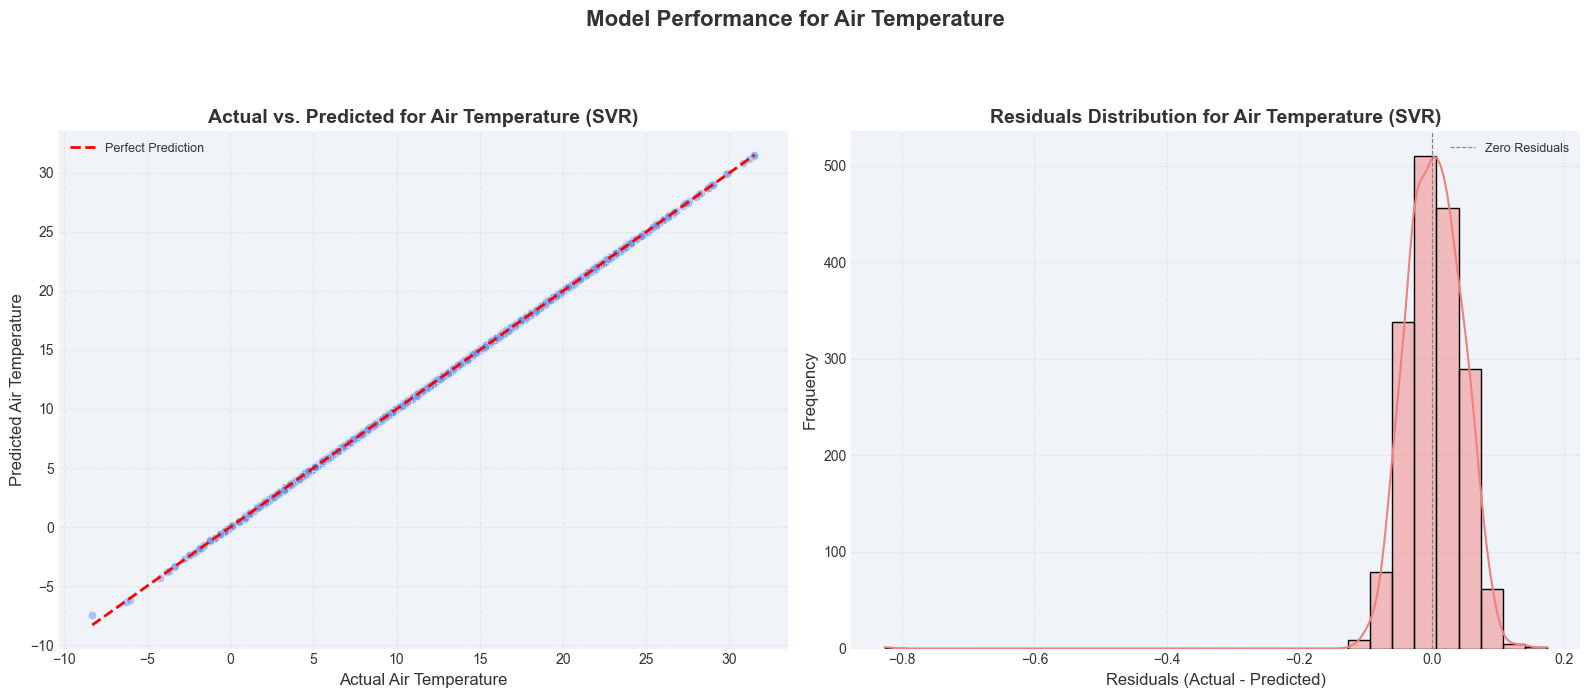

In [45]:
temp_models_to_compare = {
    'RandomForestRegressor': model_definitions['RandomForestRegressor'],
    'SVR': model_definitions['SVR']
}
run_prediction_analysis(data_df, 'air_temperature', temp_models_to_compare, summary_table, importance_threshold=0.05)

### 9.2 Relative Humidity Prediction
##### NOTE: Executes the prediction analysis for 'rltv_hum' using XGBoost and Random Forest.

INFO:root:
Starting prediction analysis for Rltv Hum
INFO:root:Selected features for rltv_hum (importance > 5.0%): ['air_temperature', 'dewpoint', 'cld_base_ht_id_1', 'visibility']
INFO:root:Train/Test split complete: 7008 training samples, 1752 testing samples
INFO:root:Feature scaling completed successfully.


Training models for Rltv Hum:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Training XGBRegressor for rltv_hum
INFO:root:Starting Random Search for XGBRegressor with 20 iterations
INFO:root:Best parameters from Random Search for XGBRegressor: {'colsample_bytree': 0.9908753883293675, 'learning_rate': 0.15727523643861177, 'max_depth': 4, 'n_estimators': 289, 'subsample': 0.9779976597381381}
INFO:root:Starting Grid Search for XGBRegressor
INFO:root:Starting Grid Search with 243 parameter combinations (729 total fits with 3-fold CV)
INFO:root:Best parameters from Grid Search for XGBRegressor: {'colsample_bytree': 0.8917878494964308, 'learning_rate': 0.15727523643861177, 'max_depth': 4, 'n_estimators': 290, 'subsample': 0.8801978937643243}
INFO:root:Evaluation metrics for XGBRegressor: MAE=0.9206, RMSE=1.1955, R²=0.9938
INFO:root:Training RandomForestRegressor for rltv_hum
INFO:root:Starting Random Search for RandomForestRegressor with 20 iterations
INFO:root:Best parameters from Random Search for RandomForestRegressor: {'max_depth': 14, 'min_samples_leaf

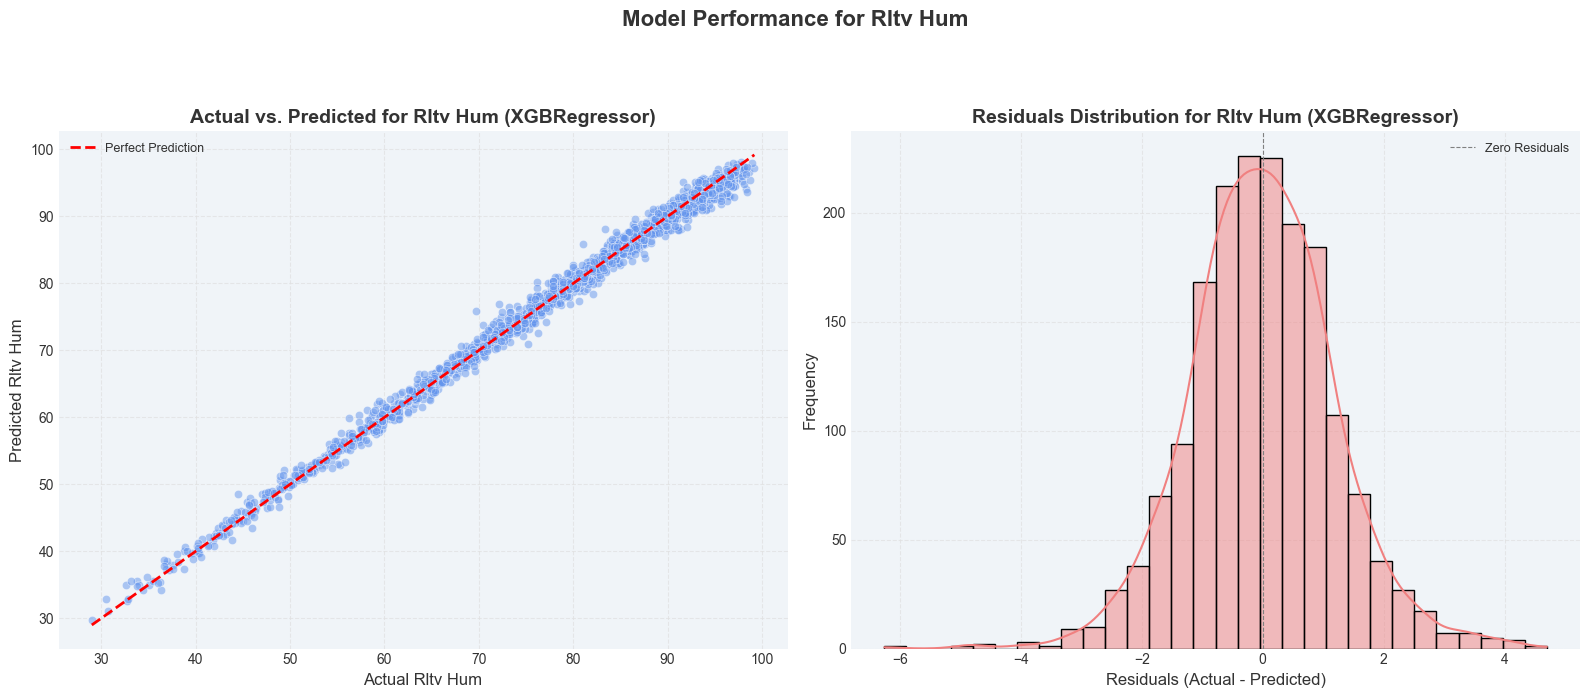

In [46]:
humidity_models_to_compare = {
    'XGBRegressor': model_definitions['XGBRegressor'],
    'RandomForestRegressor': model_definitions['RandomForestRegressor']
}
run_prediction_analysis(data_df, 'rltv_hum', humidity_models_to_compare, summary_table, importance_threshold=0.05)

### 9.3 Visibility Prediction
##### NOTE: Executes the prediction analysis for 'visibility' using XGBoost and SVR.

INFO:root:
Starting prediction analysis for Visibility
INFO:root:Selected features for visibility (importance > 5.0%): ['wetb_temp', 'rltv_hum', 'air_temperature', 'stn_pres', 'dewpoint', 'cld_base_ht_id_1', 'wind_direction', 'msl_pressure', 'wind_speed']
INFO:root:Train/Test split complete: 7008 training samples, 1752 testing samples
INFO:root:Feature scaling completed successfully.


Training models for Visibility:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Training XGBRegressor for visibility
INFO:root:Starting Random Search for XGBRegressor with 20 iterations
INFO:root:Best parameters from Random Search for XGBRegressor: {'colsample_bytree': 0.8869894380482674, 'learning_rate': 0.07287062472200334, 'max_depth': 7, 'n_estimators': 198, 'subsample': 0.8773893363123181}
INFO:root:Starting Grid Search for XGBRegressor
INFO:root:Starting Grid Search with 243 parameter combinations (729 total fits with 3-fold CV)
INFO:root:Best parameters from Grid Search for XGBRegressor: {'colsample_bytree': 0.7982904942434407, 'learning_rate': 0.06558356224980301, 'max_depth': 8, 'n_estimators': 198, 'subsample': 0.8773893363123182}
INFO:root:Evaluation metrics for XGBRegressor: MAE=676.1079, RMSE=929.3101, R²=0.6666
INFO:root:Training SVR for visibility
INFO:root:Starting Random Search for SVR with 20 iterations
INFO:root:Best parameters from Random Search for SVR: {'C': 73.22619478695937, 'gamma': 'scale', 'kernel': 'rbf'}
INFO:root:Starting Gr

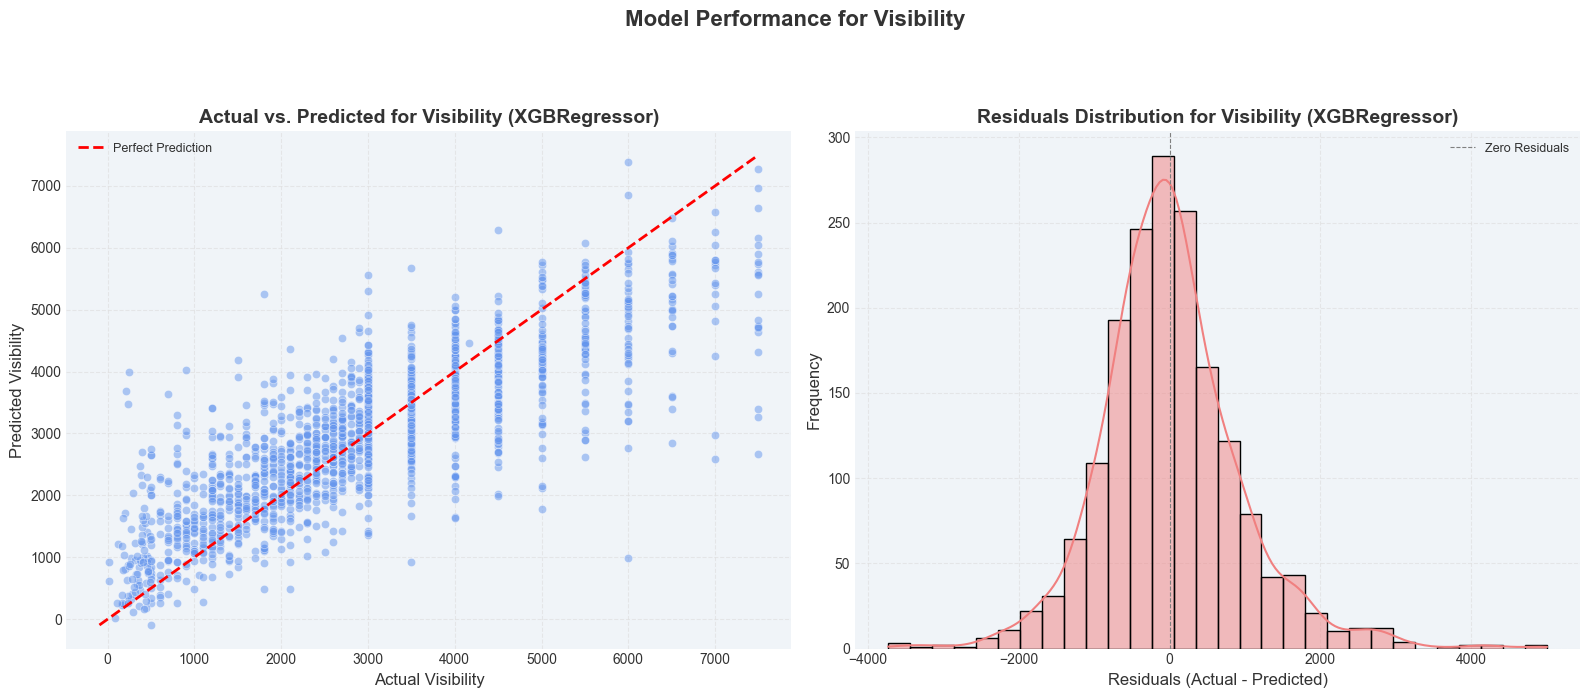

In [47]:
visibility_models_to_compare = {
    'XGBRegressor': model_definitions['XGBRegressor'],
    'SVR': model_definitions['SVR']
}
run_prediction_analysis(data_df, 'visibility', visibility_models_to_compare, summary_table, importance_threshold=0.05)

### 9.4 Wind Speed Prediction
##### NOTE: Executes the prediction analysis for 'wind_speed' using LightGBM and Random Forest.

INFO:root:
Starting prediction analysis for Wind Speed
INFO:root:Selected features for wind_speed (importance > 5.0%): ['wetb_temp', 'rltv_hum', 'air_temperature', 'stn_pres', 'dewpoint', 'cld_base_ht_id_1', 'wind_direction', 'visibility', 'msl_pressure']
INFO:root:Train/Test split complete: 7008 training samples, 1752 testing samples
INFO:root:Feature scaling completed successfully.


Training models for Wind Speed:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Training LightGBMRegressor for wind_speed
INFO:root:Starting Random Search for LGBMRegressor with 20 iterations
INFO:root:Best parameters from Random Search for LGBMRegressor: {'learning_rate': 0.09458327528535912, 'max_depth': 7, 'n_estimators': 174, 'num_leaves': 30, 'reg_alpha': 0.17323522915498704, 'reg_lambda': 0.12022300234864176}
INFO:root:Starting Grid Search for LGBMRegressor
INFO:root:Starting Grid Search with 729 parameter combinations (2187 total fits with 3-fold CV)
INFO:root:Best parameters from Grid Search for LGBMRegressor: {'learning_rate': 0.10404160281389505, 'max_depth': 8, 'n_estimators': 174, 'num_leaves': 30, 'reg_alpha': 0.19055875207048575, 'reg_lambda': 0.13224530258350595}
INFO:root:Evaluation metrics for LightGBMRegressor: MAE=1.8085, RMSE=2.3706, R²=0.7021
INFO:root:Training RandomForestRegressor for wind_speed
INFO:root:Starting Random Search for RandomForestRegressor with 20 iterations
INFO:root:Best parameters from Random Search for RandomFores

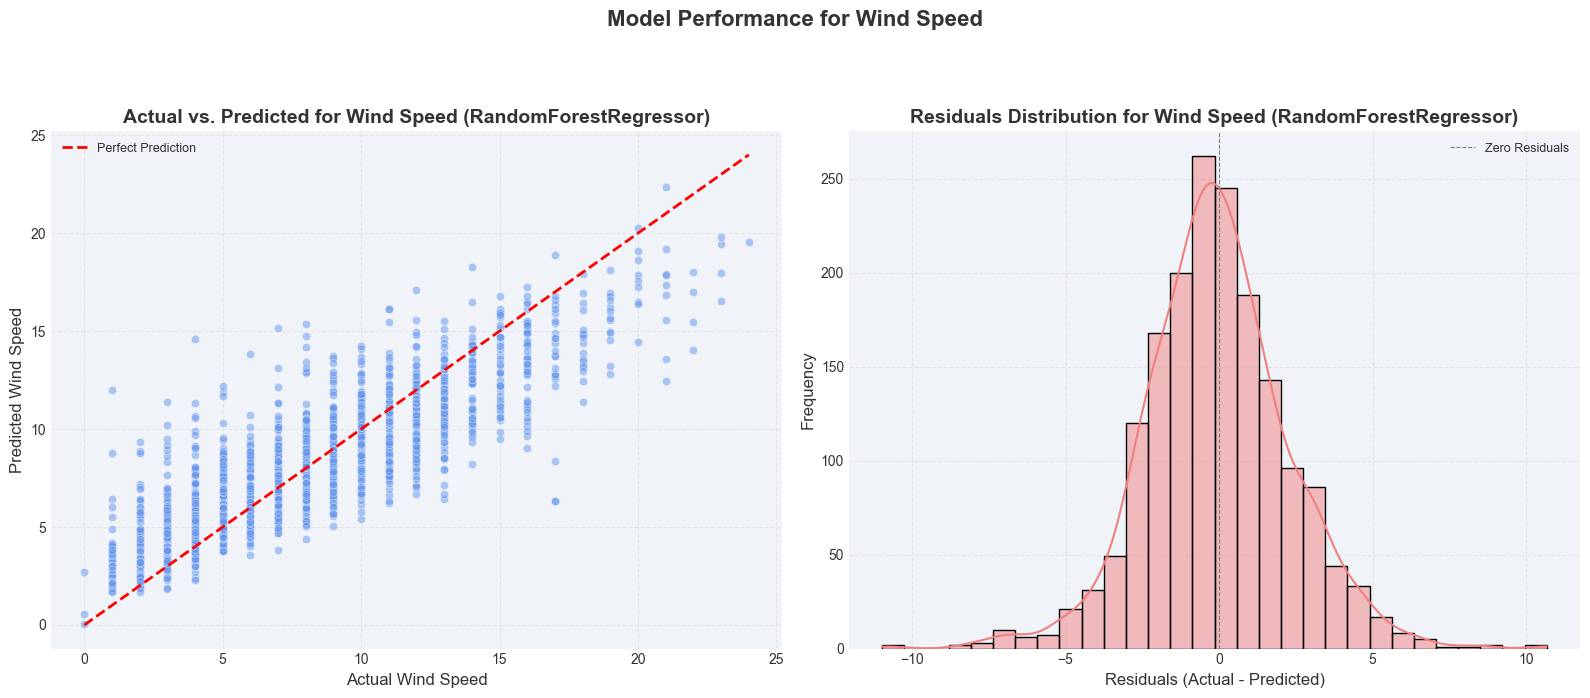

In [52]:
wind_speed_models_to_compare = {
    'LightGBMRegressor': model_definitions['LightGBMRegressor'],
    'RandomForestRegressor': model_definitions['RandomForestRegressor']
}
run_prediction_analysis(data_df, 'wind_speed', wind_speed_models_to_compare, summary_table, importance_threshold=0.05)

# 10. Model Saving Logic
##### NOTE: This section is used to save the models trained for future usage.
##### Pickle is usually used for saving models as it is simpler, but it is not the best for saving numpy arrays and can also be used to execute malicious code, so Joblib Dump function is used instead.

In [53]:
logging.info("\nSaving Best Trained Models")

if not GLOBAL_BEST_MODELS:
    logging.warning("No models were stored in GLOBAL_BEST_MODELS. Please ensure run_prediction_analysis executed successfully for targets.")
else:
    for target_name, model_info in GLOBAL_BEST_MODELS.items():
        try:
            model_object = model_info['model']
            model_scaler = model_info['scaler'] # Retrieve the scaler

            # Clean target_name for filename
            clean_target_name = target_name.replace('_', '-')

            # Save the model
            model_filename = os.path.join(MODELS_SAVE_DIR, f'best_model_{clean_target_name}.joblib')
            joblib.dump(model_object, model_filename)
            logging.info(f"Best model for '{target_name.replace('_', ' ').title()}' saved to: {model_filename}")

            # Save the scaler needed for future predictions with the saved model
            scaler_filename = os.path.join(MODELS_SAVE_DIR, f'scaler_{clean_target_name}.joblib')
            joblib.dump(model_scaler, scaler_filename)
            logging.info(f"Scaler for '{target_name.replace('_', ' ').title()}' saved to: {scaler_filename}")

        except Exception as e:
            logging.error(f"Failed to save model or scaler for '{target_name}': {e}", exc_info=True)

logging.info("\nModel Saving Process Complete")

INFO:root:
Saving Best Trained Models
INFO:root:Best model for 'Air Temperature' saved to: _models\best_model_air-temperature.joblib
INFO:root:Scaler for 'Air Temperature' saved to: _models\scaler_air-temperature.joblib
INFO:root:Best model for 'Rltv Hum' saved to: _models\best_model_rltv-hum.joblib
INFO:root:Scaler for 'Rltv Hum' saved to: _models\scaler_rltv-hum.joblib
INFO:root:Best model for 'Visibility' saved to: _models\best_model_visibility.joblib
INFO:root:Scaler for 'Visibility' saved to: _models\scaler_visibility.joblib
INFO:root:Best model for 'Wind Speed' saved to: _models\best_model_wind-speed.joblib
INFO:root:Scaler for 'Wind Speed' saved to: _models\scaler_wind-speed.joblib
INFO:root:
Model Saving Process Complete


# 11. Model Loading Logic
##### NOTE: This section is used to load the models trained with Joblib.

In [ ]:
rint(f"Attempting to load models from: {MODELS_SAVE_DIR}")

# Dictionary to store the loaded models and their scalers
loaded_models = {}
loaded_scalers = {}

# List of target variables for which you saved models
target_variables = ['air_temperature', 'rltv_hum', 'visibility', 'wind_speed']

for target_col in target_variables:
    clean_target_name = target_col.replace('_', '-')
    model_filename = os.path.join(MODELS_SAVE_DIR, f'best_model_{clean_target_name}.joblib')
    scaler_filename = os.path.join(MODELS_SAVE_DIR, f'scaler_{clean_target_name}.joblib')

    if os.path.exists(model_filename) and os.path.exists(scaler_filename):
        try:
            model = joblib.load(model_filename)
            scaler = joblib.load(scaler_filename)
            loaded_models[target_col] = model
            loaded_scalers[target_col] = scaler
            logging.info(f"Successfully loaded model and scaler for '{target_col}'.")
        except Exception as e:
            logging.error(f"Error loading model or scaler for '{target_col}': {e}")
    else:
        logging.warning(f"Model or scaler files not found for '{target_col}' at {model_filename} and {scaler_filename}.")

### 11.1 Using a Loaded Model
##### NOTE: Ensure the model was loaded in section 11.

In [ ]:
if 'air_temperature' in loaded_models:
    logging.info("\nUsing the loaded 'air_temperature' model.")
    temp_model = loaded_models['air_temperature']
    temp_scaler = loaded_scalers['air_temperature']

    # Have new dataframe here that needs to be used to predict future values
    # df_for_prediction = []

    # Scale the new data using the same scaler that was used during training
    scaled_new_data = temp_scaler.transform(df_for_prediction)
    
    # Make predictions
    predictions = temp_model.predict(scaled_new_data)
    logging.info(f"Predictions for air_temperature: {predictions}")
else:
    logging.errfor("\nAir temperature model not loaded. Cannot run example prediction.")